#Modelo detector de toxicidad multilingüe (español, inglés, francés) en _tweets_ y artículos de noticias entrenado mediante _fine-tuning_

Autor: Alba María García García

Fecha: 28-Nov-2023

<u>Recursos</u>:
- Datos en _train_ y _test_ en formato CSV.

<u>Requisitos</u>:
- Python >= 3.7
- Realizar un análisis descriptivo de los datos.
- Sin restricciones en el preprocesado.
- Se entregan datos de para el entrenamiento, pero se pueden modificar o utilizar otros.
- Realizar entrenamiento mediante _fine-tuning_.
- El modelo debe funcionar como mínimo en los idiomas español, inglés y francés.
- La evaluación final se debe hacer sobre los datos de _test_ entregados.
- Realizar un análisis de errores sobre el conjunto de _test_ (sesgos, etc).
- Subir el _notebook_ a un repositorio de GitHub público.

<u>Cuestiones</u>:
- ¿Sería buena idea resolver este problema usando un LLM?

## Preparación del entorno

Comprobamos que la versión nativa de Python de Google Colab es superior a 3.7.

In [1]:
!python --version

Python 3.10.12


Clonamos el repositorio de GitHub donde he subido los recursos de la prueba, los requisitos (librerías) y las constantes y funciones auxiliares (_utils_). Estas últimas se han separado del _notebook_ por legibilidad y limpieza.

In [2]:
!git clone https://github.com/Akvamarin/toxicity_analysis.git

Cloning into 'toxicity_analysis'...
remote: Enumerating objects: 139, done.
remote: Counting objects: 100% (44/44), done.
remote: Compressing objects: 100% (32/32), done.
remote: Total 139 (delta 31), reused 12 (delta 12), pack-reused 95
Receiving objects: 100% (139/139), 5.18 MiB | 8.12 MiB/s, done.
Resolving deltas: 100% (62/62), done.


Permitimos que Google Colab tenga acceso a Google Drive para poder cargar allí los _checkpoints_ del entrenamiento y que estos no se pierdan debido a algún reinicio de sesión por haberlos guardado en local.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Instalamos todas las librerías (dependencias) definidas en requirements.txt.

In [4]:
!pip install -r toxicity_analysis/requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.4/53.4 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 32.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 27.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.4/175.4 kB 23.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for emoji: filename=emoji-1.7.0-py3-none-any.whl size=171031 sha256=f1571c034b51cb79cd8662061ada6a1f7d36b5f7c59c46d1a795d039704b77ad
  Stored in directory: /root/.cache/pip/wheels/31/8a/8c/315c9e5d7773f74b33d5ed33f075b49c6eaeb7cedbb86e2cf8
Successfully built emoji
  Attempting uninstall: wcwidth
    Found existing installation: wcwidth 0.2.10
    Uninstalling wcwidth-0.2.10:
      Successfully uninstalled wcwidth-0.2.10


##Preparación y limpieza de los datos

In [5]:
import os
import pandas as pd

from toxicity_analysis.utils.constants import REPO_NAME, ID, TEXT, LABEL, ORIGIN, ID_TYPE, ENGLISH, FRENCH

Cargamos los dataset de _train_ y _test_ en sus respectivos DataFrame a partir de sus _path_ en el repositorio de GitHub, no sin antes definir los tipos de cada una de sus variables manualmente para evitar que lo haga Pandas automáticamente asignando tipos _object_ que pueden producir errores de compatibilidad y degradar el rendimiento.

In [6]:
# State train and test dataset paths
train_path = os.path.join(os.getcwd(), REPO_NAME, 'data', 'toxicity_train_augmented_senior_20231102.csv')
test_path = os.path.join(os.getcwd(), REPO_NAME, 'data', 'toxicity_test_augmented_senior_20231102.csv')

# [Sanity check] State the expected data types
data_types = {
      ID: 'string',
      TEXT: 'string',
      LABEL: 'uint8',
      ORIGIN: 'string',
      ID_TYPE: 'string',
      ENGLISH: 'string',
      FRENCH: 'string'
}

# Load train and test data to a DataFrame (assuming encoding UTF-8)
# We'll review data encoding more in detail later on
df_train_val = pd.read_csv(train_path, encoding='utf-8', dtype=data_types)
df_test = pd.read_csv(test_path, encoding='utf-8', dtype=data_types)

# Validate that there are no missing columns
assert df_train_val.shape[-1] == df_test.shape[-1], f"Both datasets must have the same number of columns.\n"\
                                                    f"TRAIN cols: {df_train_val.shape[-1]}, TEST cols: {df_test.shape[-1]}"

# Get datasets' shape
print(f"TRAIN shape: {df_train_val.shape}. TEST shape: {df_test.shape}")

TRAIN shape: (11000, 7). TEST shape: (5000, 7)


Tenemos **11.000 ejemplos de texto en _train_ y 5.000 en _test_**. Se trata de un dataset de entrenamiento bastante reducido, aunque esto no es tan relevante cuando no vamos a realizar un entrenamiento desde cero.

In [7]:
from toxicity_analysis.utils.analysis_utils import style_dataframe

Mostramos las cinco primeras filas de los datos de entrenamiento haciendo uso de la función "style_dataframe", creada para mostrar los DataFrame de forma más _estética_ y conveniente.

In [8]:
# Show the first five rows
style_dataframe(df_train_val)

id,text,label,origin,id-type,english,french
https://www.elplural.com/politica/espana/polemica-respuesta-espinosa-monteros-marlaska-despedida-julio-anguita-no-respetaron-distancias_240104102,"Durante su intervenciÃ³n, el vicesecretario de Vox tambiÃ©n ha dejado patente la crisis a la que se enfrenta la derecha despuÃ©s de que Ciudadanos apoyase la pasada prÃ³rroga del estado de alarma, como se espera que tambiÃ©n apoye la que se debate maÃ±ana.",0,news-articles,url,"Espinosa de los Monteros has compared both protests to the funeral of the former leader of IU and former mayor of Córdoba, Julio Anguita, who passed away on May 16th due to a cardiac arrest.","Espinosa de los Monteros a comparé les deux manifestations avec les funérailles de l'ancien dirigeant d'IU et ancien maire de Cordoue, Julio Anguita, décédé le 16 mai dernier d'un arrêt cardiaque."
1.271010900259078e+18,"Nueva manipulaciÃ³n a la mujer de la @rfef, dÃ³nde se quedÃ³ la igualdad ante la Ley del art 14 de la ConstituciÃ³n @VOX_Congreso seguirÃ¡ luchando. https://t.co/qopoFRbqyQ",1,twitter,twitterId,"New manipulation of the woman from @rfef, where is the equality before the Law of article 14 of the Constitution @VOX_Congreso will continue fighting. https://t.co/qopoFRbqyQ","Nouvelle manipulation de la femme de la @rfef, où est passée l'égalité devant la loi de l'article 14 de la Constitution @VOX_Congreso continuera à se battre. https://t.co/qopoFRbqyQ"
1.2986035925013957e+18,SOLIDARIDAD con los 500 trabajadores de Acciona que se enfrentan a un ERE. âï¸El gobierno mÃ¡s preocupado de sus polÃ­ticas progres que de crear un tejido industrial fuerte. âï¸Los sindicatos cÃ³mplices preocupados por agradar al gobierno. https://t.co/CqJnPAKzfx,1,twitter,twitterId,SOLIDARITY with the 500 Acciona workers facing a redundancy plan. âï¸The government more concerned about its progressive policies than creating a strong industrial fabric. âï¸The complicit unions worried about pleasing the government. https://t.co/CqJnPAKzfx,SOLIDARITÉ avec les 500 travailleurs d'Acciona qui font face à un ERE. âï¸Le gouvernement plus préoccupé par ses politiques progressistes que par la création d'un tissu industriel solide. âï¸Les syndicats complices préoccupés par plaire au gouvernement. https://t.co/CqJnPAKzfx
1.2811132626507776e+18,"âï¸ #BuenosDÃ­as #FelizJueves MaÃ±ana nuestra candidata a la Xunta @Beatriz_Pino_ , estarÃ¡ acompaÃ±ada de @Tonicanto1 y @GuillermoDiazCs en #SantiagodeCompostela #StopNacionalismo Alameda â° 12:30h Â¡Te esperamos! #MoitoQueGaÃ±ar https://t.co/fbpFEv9aiu",0,twitter,twitterId,"âï¸ #GoodMorning #HappyThursday Tomorrow our candidate for the Xunta @Beatriz_Pino_, will be accompanied by @Tonicanto1 and @GuillermoDiazCs in #SantiagodeCompostela #StopNationalism Alameda â° 12:30pm We'll be waiting for you! #MuchToGain https://t.co/fbpFEv9aiu","âï¸ #Bonjour #JoyeuxJeudi Demain notre candidate à la Xunta @Beatriz_Pino_, sera accompagnée de @Tonicanto1 et @GuillermoDiazCs à #SantiagodeCompostela #StopNacionalismo Alameda â° 12h30 Nous t'attendons ! #BeaucoupAGagner https://t.co/fbpFEv9aiu"
1.465632198984405e+18,"Porros o educaciÃ³n gratuita. Adoctrinamiento progre o educaciÃ³n gratuita y exigente. Fracaso escolar o educaciÃ³n gratuita, exigente y de calidad. Juventud sumisa o juventud con futuro. CuestiÃ³n de prioridades, cuestiÃ³n de agendas. https://t.co/GAN7aeqtby",1,twitter,twitterId,"Joints or free education. Progressive indoctrination or free and demanding education. School failure or free, demanding and quality education. Submissive youth or youth with a future. A matter of priorities, a matter of agendas. https://t.co/GAN7aeqtby","Joints ou éducation gratuite. Endoctrinement progressiste ou éducation gratuite et exigeante. Échec scolaire ou éducation gratuite, exigeante et de qualité. Jeunesse soumise ou jeunesse avec un avenir. Question de priorités, question d'agendas. https://t.co/GAN7aeqtby"


Podemos observar que la estructura de los datos es acorde con la descripción del enunciado, pero también que existen dos problemas:
- Existe un **problema de codificación generalizado**. A pesar de haber cargado los datos usando encoding='utf-8', no se muestran correctamente los caracteres acentuados ni los emojis (probablemente la letra "ñ" tampoco). Es posible que los textos estuvieran ya corruptos de antemano.
- **Las traducciones** en los campos "english" y "french" **no siempre corresponden con el texto que aparece en "text"**. De todas formas, no supone ningún problema siempre que no estén mezcladas traducciones de contenido tóxico en entradas no tóxicas y viceversa.

Antes de continuar con estos problemas, vamos a comprobar si existen _missing values_ en los datos de entrenamiento y test.

In [9]:
# Find if there are missing values
print(f"TRAIN missing values:\n\n{df_train_val.isna().sum()}")

TRAIN missing values:

id            0
text          0
label         0
origin        0
id-type       0
english    1040
french     1041
dtype: int64


In [10]:
print(f"TEST missing values:\n\n{df_test.isna().sum()}")

TEST missing values:

id          0
text        0
label       0
origin      0
id-type     0
english    13
french     10
dtype: int64


Observamos que **sólo existen _missing values_ en los campos "english" y "french"** (traducciones). Esto no supone ningún problema porque en el futuro dataset de entrenamiento, las traducciones serán independientes de sus textos originales y en los casos que no existan, serán simplemente ignoradas.

Ahora, procedemos a resolver el problema de la codificación incorrecta.

In [11]:
import chardet

In [12]:
# Let's check if chardet shares our opinion about UTF-8 encoding just in case
with open(train_path, 'rb') as f:
  # Read the first 10K bytes to get a charset guess
  sample_bytes = f.read(10000)
  # Infer the charset
  inferred_charset = chardet.detect(sample_bytes)

print(f"Inferred encoding: {inferred_charset['encoding']} (confidence: {inferred_charset['confidence']})")

Inferred encoding: utf-8 (confidence: 0.99)


Volvemos a leer el fichero de entrenamiento, pero esta vez en modo binario, es decir, como _bytes_ en lugar de cadenas de texto para evitar forzar ningún tipo de codificación y poder **conocer su codificación nativa**. Dicha codificación ha resultado ser la previamente asumida <u>UTF-8</u>, por lo que podemos confirmar que, efectivamente, **los datos estaban corruptos**.

Procedemos, por tanto a _limpiar_ el texto mediante la librería ftfy.

In [13]:
import ftfy
from pandas import NA

In [14]:
# We can conclude that decoding errors are not coming from an incorrect charset.
# Thus, we proceed to correct them in both data splits (train and test)

input_text_columns = [TEXT, ENGLISH, FRENCH]  # Affected columns

# Define the cast function to correct these errors, letting missing values as they are
cast_func = lambda text: str(ftfy.fix_text(text)) if text is not NA else text

# Apply this correction to both datasets
for column in input_text_columns:
  df_train_val[column] = df_train_val[column].apply(cast_func).astype('string')
  df_test[column] = df_test[column].apply(cast_func).astype('string')

In [15]:
# Show the data again to make sure data corruption has been corrected
style_dataframe(df_train_val)

id,text,label,origin,id-type,english,french
https://www.elplural.com/politica/espana/polemica-respuesta-espinosa-monteros-marlaska-despedida-julio-anguita-no-respetaron-distancias_240104102,"Durante su intervención, el vicesecretario de Vox también ha dejado patente la crisis a la que se enfrenta la derecha después de que Ciudadanos apoyase la pasada prórroga del estado de alarma, como se espera que también apoye la que se debate mañana.",0,news-articles,url,"Espinosa de los Monteros has compared both protests to the funeral of the former leader of IU and former mayor of Córdoba, Julio Anguita, who passed away on May 16th due to a cardiac arrest.","Espinosa de los Monteros a comparé les deux manifestations avec les funérailles de l'ancien dirigeant d'IU et ancien maire de Cordoue, Julio Anguita, décédé le 16 mai dernier d'un arrêt cardiaque."
1.271010900259078e+18,"Nueva manipulación a la mujer de la @rfef, dónde se quedó la igualdad ante la Ley del art 14 de la Constitución @VOX_Congreso seguirá luchando. https://t.co/qopoFRbqyQ",1,twitter,twitterId,"New manipulation of the woman from @rfef, where is the equality before the Law of article 14 of the Constitution @VOX_Congreso will continue fighting. https://t.co/qopoFRbqyQ","Nouvelle manipulation de la femme de la @rfef, où est passée l'égalité devant la loi de l'article 14 de la Constitution @VOX_Congreso continuera à se battre. https://t.co/qopoFRbqyQ"
1.2986035925013957e+18,SOLIDARIDAD con los 500 trabajadores de Acciona que se enfrentan a un ERE. ✖️El gobierno más preocupado de sus políticas progres que de crear un tejido industrial fuerte. ✖️Los sindicatos cómplices preocupados por agradar al gobierno. https://t.co/CqJnPAKzfx,1,twitter,twitterId,SOLIDARITY with the 500 Acciona workers facing a redundancy plan. ✖️The government more concerned about its progressive policies than creating a strong industrial fabric. ✖️The complicit unions worried about pleasing the government. https://t.co/CqJnPAKzfx,SOLIDARITÉ avec les 500 travailleurs d'Acciona qui font face à un ERE. ✖️Le gouvernement plus préoccupé par ses politiques progressistes que par la création d'un tissu industriel solide. ✖️Les syndicats complices préoccupés par plaire au gouvernement. https://t.co/CqJnPAKzfx
1.2811132626507776e+18,"☀️ #BuenosDías #FelizJueves Mañana nuestra candidata a la Xunta @Beatriz_Pino_ , estará acompañada de @Tonicanto1 y @GuillermoDiazCs en #SantiagodeCompostela #StopNacionalismo Alameda ⏰ 12:30h ¡Te esperamos! #MoitoQueGañar https://t.co/fbpFEv9aiu",0,twitter,twitterId,"☀️ #GoodMorning #HappyThursday Tomorrow our candidate for the Xunta @Beatriz_Pino_, will be accompanied by @Tonicanto1 and @GuillermoDiazCs in #SantiagodeCompostela #StopNationalism Alameda ⏰ 12:30pm We'll be waiting for you! #MuchToGain https://t.co/fbpFEv9aiu","☀️ #Bonjour #JoyeuxJeudi Demain notre candidate à la Xunta @Beatriz_Pino_, sera accompagnée de @Tonicanto1 et @GuillermoDiazCs à #SantiagodeCompostela #StopNacionalismo Alameda ⏰ 12h30 Nous t'attendons ! #BeaucoupAGagner https://t.co/fbpFEv9aiu"
1.465632198984405e+18,"Porros o educación gratuita. Adoctrinamiento progre o educación gratuita y exigente. Fracaso escolar o educación gratuita, exigente y de calidad. Juventud sumisa o juventud con futuro. Cuestión de prioridades, cuestión de agendas. https://t.co/GAN7aeqtby",1,twitter,twitterId,"Joints or free education. Progressive indoctrination or free and demanding education. School failure or free, demanding and quality education. Submissive youth or youth with a future. A matter of priorities, a matter of agendas. https://t.co/GAN7aeqtby","Joints ou éducation gratuite. Endoctrinement progressiste ou éducation gratuite et exigeante. Échec scolaire ou éducation gratuite, exigeante et de qualité. Jeunesse soumise ou jeunesse avec un avenir. Question de priorités, question d'agendas. https://t.co/GAN7aeqtby"


Podemos comprobar que han aparecidos las tildes y los emojis, <u>estos textos ya sí son legibles sin dificultad</u>. Finalmente, comprobemos que el texto no presenta caracteres indeseados como pueden ser ￼ o �.

In [16]:
texts_with_missing_characters = {}
# Look for other replacement characters due to unicode decode errors
for symbol in ('￼', '�'):
    texts_with_missing_characters[symbol] = df_train_val[df_train_val['text'].str.contains(symbol)]

In [17]:
print("Character OBJ\n")
style_dataframe(texts_with_missing_characters['￼'])

Character OBJ



id,text,label,origin,id-type,english,french


In [18]:
print("Character �\n")
style_dataframe(texts_with_missing_characters['�'])

Character �



id,text,label,origin,id-type,english,french
http://kioskoymas.abc.es/noticias/opinion-editoriales/20150426/abcp-toreros-quiza-seamos-ultimos-20150426.html?utm_source=abc&utm_medium=rss&utm_content=uh-rss&utm_campaign=traffic-rss,"Hondo e inspirado, el matador madrile�o charla con ABC desde su retiro en el campo extreme�o, donde prepara su en�simo examen en Las Ventas.",0,news-articles,url,Subscribe to read the full news.,Abonnez-vous pour lire l'article complet.
http://kioskoymas.abc.es/noticias/opinion-enfoque/20150219/abcp-junta-apuesta-romanico-zamorano-20150219.html?utm_source=abc&utm_medium=rss&utm_content=uh-rss&utm_campaign=traffic-rss,"La Consejer�a de Cultura y Turismo mostr� ayer su voluntad de desarrollar una segunda fase de los programas de restauraci�n, conservaci�n, difusi�n y divulgaci�n �Zamora Rom�nica� y �Rom�nico Atl�ntico�, dos planes de actuaci�n sobre templos en los que participa la Junta de Castilla y Le�n con el fin de salvaguardar el patrimonio.",0,news-articles,url,"The Ministry of Culture and Tourism showed yesterday its willingness to develop a second phase of the restoration, conservation, dissemination, and promotion programs ""Zamora Románica"" and ""Románico Atlántico"", two action plans on temples in which the Junta de Castilla y León participates in order to safeguard the heritage.","Le ministère de la Culture et du Tourisme a montré hier sa volonté de développer une deuxième phase des programmes de restauration, de conservation, de diffusion et de divulgation ""Zamora Románica"" et ""Románico Atlántico"", deux plans d'action sur les temples auxquels participe la Junta de Castilla y León afin de sauvegarder le patrimoine."
http://kioskoymas.abc.es/noticias/opinion-editoriales/20150505/abcp-humo-contra-corrupcion-andaluzahumo-20150505.html?utm_source=abc&utm_medium=rss&utm_content=uh-rss&utm_campaign=traffic-rss,SUSANA D�az dio ayer el primer paso para ser investida presidenta andaluza.,0,news-articles,url,Susana Díaz took the first step yesterday to be sworn in as president of Andalusia.,SUSANA Díaz a fait hier le premier pas pour être investie présidente andalouse.
http://kioskoymas.abc.es/noticias/opinion/20150301/abcp-mundial-superbike-20150301.html?utm_source=abc&utm_medium=rss&utm_content=uh-rss&utm_campaign=traffic-rss,"En este caso es JAVIER DEL CERRO quien nos reprocha que �como seguidor de su web, motorista y apasionado a las motos, me parece algo incre�",0,news-articles,url,"In this case, it is JAVIER DEL CERRO who reproaches us that as a follower of his website, motorcyclist, and passionate about motorcycles, it seems incredible to me.","Dans ce cas, c'est JAVIER DEL CERRO qui nous reproche que ""en tant que fidèle de son site web, motard et passionné de motos, cela me semble incroyable""."


Comprobamos que no hay ninguna incidencia con el caracter ￼, pero sí con el caracter �. De todas formas, se trata de un problema aislado de las noticias de la web "kioskoymas.abc.es" y se puede solucionar manualmente. (Normalmente, este tipo de errores de decodificación no son tan sencillos de resolver como los anteriores).

In [19]:
# As they are just four erroneous entries, we can directly fix them manually
# (There is no clear simple and escalable solution for this)
corrected_texts = [
    "Hondo e inspirado, el matador madrileño charla con ABC desde su retiro en el campo extremeño, donde prepara su enésimo examen en Las Ventas.",
    "La Consejería de Cultura y Turismo mostró ayer su voluntad de desarrollar una segunda fase de los programas de restauración, conservación, difusión y divulgación 'Zamora Románica' y 'Románico Atlántico', dos planes de actuación sobre templos en los que participa la Junta de Castilla y León con el fin de salvaguardar el patrimonio.",
    "SUSANA Díaz dio ayer el primer paso para ser investida presidenta andaluza.",
    "En este caso es JAVIER DEL CERRO quien nos reprocha que, como seguidor de su web, motorista y apasionado a las motos, me parece algo increíble."
]

# Update the DataFrame with the correct texts
df_train_val.loc[texts_with_missing_characters['�'].index, TEXT] = corrected_texts

assert (df_train_val['text'].str.contains('�') == False).all(), f"There are still � symbols within the data."
style_dataframe(df_train_val.loc[texts_with_missing_characters['�'].index])

id,text,label,origin,id-type,english,french
http://kioskoymas.abc.es/noticias/opinion-editoriales/20150426/abcp-toreros-quiza-seamos-ultimos-20150426.html?utm_source=abc&utm_medium=rss&utm_content=uh-rss&utm_campaign=traffic-rss,"Hondo e inspirado, el matador madrileño charla con ABC desde su retiro en el campo extremeño, donde prepara su enésimo examen en Las Ventas.",0,news-articles,url,Subscribe to read the full news.,Abonnez-vous pour lire l'article complet.
http://kioskoymas.abc.es/noticias/opinion-enfoque/20150219/abcp-junta-apuesta-romanico-zamorano-20150219.html?utm_source=abc&utm_medium=rss&utm_content=uh-rss&utm_campaign=traffic-rss,"La Consejería de Cultura y Turismo mostró ayer su voluntad de desarrollar una segunda fase de los programas de restauración, conservación, difusión y divulgación 'Zamora Románica' y 'Románico Atlántico', dos planes de actuación sobre templos en los que participa la Junta de Castilla y León con el fin de salvaguardar el patrimonio.",0,news-articles,url,"The Ministry of Culture and Tourism showed yesterday its willingness to develop a second phase of the restoration, conservation, dissemination, and promotion programs ""Zamora Románica"" and ""Románico Atlántico"", two action plans on temples in which the Junta de Castilla y León participates in order to safeguard the heritage.","Le ministère de la Culture et du Tourisme a montré hier sa volonté de développer une deuxième phase des programmes de restauration, de conservation, de diffusion et de divulgation ""Zamora Románica"" et ""Románico Atlántico"", deux plans d'action sur les temples auxquels participe la Junta de Castilla y León afin de sauvegarder le patrimoine."
http://kioskoymas.abc.es/noticias/opinion-editoriales/20150505/abcp-humo-contra-corrupcion-andaluzahumo-20150505.html?utm_source=abc&utm_medium=rss&utm_content=uh-rss&utm_campaign=traffic-rss,SUSANA Díaz dio ayer el primer paso para ser investida presidenta andaluza.,0,news-articles,url,Susana Díaz took the first step yesterday to be sworn in as president of Andalusia.,SUSANA Díaz a fait hier le premier pas pour être investie présidente andalouse.
http://kioskoymas.abc.es/noticias/opinion/20150301/abcp-mundial-superbike-20150301.html?utm_source=abc&utm_medium=rss&utm_content=uh-rss&utm_campaign=traffic-rss,"En este caso es JAVIER DEL CERRO quien nos reprocha que, como seguidor de su web, motorista y apasionado a las motos, me parece algo increíble.",0,news-articles,url,"In this case, it is JAVIER DEL CERRO who reproaches us that as a follower of his website, motorcyclist, and passionate about motorcycles, it seems incredible to me.","Dans ce cas, c'est JAVIER DEL CERRO qui nous reproche que ""en tant que fidèle de son site web, motard et passionné de motos, cela me semble incroyable""."


Comprobamos, finalmente, que **todos los problemas de decodificación han desaparecido**.

# Análisis descriptivo de los datos

En esta sección vamos a conocer el balanceo de clases en los datos, así como el contenido de los mismos en rasgos generales. En un principio, sabemos que éstos se han obtenido de dos fuentes: Twitter y páginas web de noticias (todo apunta que de carácter generalista).

## Balanceo de clases

In [20]:
from toxicity_analysis.utils.analysis_utils import get_norm_crosstab, visualize_norm_crosstab

Para conocer la distribución de las clases en nuestro dataset, voy a emplear la _cross tabulation_ o _contingency table_, que no es más que una tabla donde se enfrentan dos variables de un conjunto de datos para mostrar el número de ocurrencias para las diferentes combinaciones de valores en ambas variables o sólo en una de ellas. En este caso, las variables objetivo son la clase y el origen de los datos.

In [21]:
# Get cross tabs for both train and test datasets
train_val_crosstab = get_norm_crosstab(df_train_val, rows_label=LABEL, columns_label=ORIGIN)
test_crosstab = get_norm_crosstab(df_test, rows_label=LABEL, columns_label=ORIGIN)

In [22]:
visualize_norm_crosstab(train_val_crosstab, "Crosstab for TRAIN", rows_name=LABEL, columns_name=ORIGIN)

origin / label,news-articles,twitter,TOTAL (origin)
0,52.87%,20.60%,73.47%
1,1.47%,25.05%,26.53%
TOTAL (label),54.35%,45.65%,100.00%


In [23]:
visualize_norm_crosstab(test_crosstab, "Crosstab for TEST", rows_name=LABEL, columns_name=ORIGIN)

origin / label,news-articles,twitter,TOTAL (origin)
0,42.54%,43.62%,86.16%
1,1.26%,12.58%,13.84%
TOTAL (label),43.80%,56.20%,100.00%


Podemos hacer las siguientes observaciones:
- **Los datos están claramente desbalanceados** en ambos casos, aunque especialmente en los datos de _test_: existen más textos no tóxicos que tóxicos.
- Esto es debido a que los contenidos tóxicos provienen de forma prácticamente exclusiva de Twitter (si un texto es tóxico, hay un 90-95% de probabilidades que provenga de Twitter). El contenido de los artículos de noticias es abrumadoramente no tóxico (alrededor del 97%).
- En resumen, el contenido de Twitter es tanto tóxico como no tóxico (en proporciones diferentes dependiendo de cuándo se obtuvieron los datos), mientras que el contenido de los artículos de noticias es casi al 100% no tóxico.

Por tanto, **añadir cualquier información acerca del origen de los datos crearía un sesgo muy fuerte** en el clasificador que no le permitiría generalizar correctamente (¿Qué pasa si cambia la distribución de los datos y al modelo le empiezan a llegar artículos de noticias muy tóxicas? Porque estas noticias también existen).

El desbalanceo de clases se puede tratar de dos maneras:
- Aumentando artificialmente los datos de entrenamiento (data augmentation).
- **Ponderando la función de _loss_** del modelo durante el entrenamiento de forma proporcionalmente inversa a la distribución de clases.

He optado por la segunda por su mayor simplicidad de implementación.

##Contenido semántico de los datos

En esta subsección nos vamos a ayudar de la librerías spacy y matplotlib para analizar el **contenido semántico** de los datos de entrenamiento y _test_. Por limitación de tiempo, me he centrado en analizar <u>sólo los contenidos en español</u>, ya que son los mayoritarios (no presentan _missing values_) y también los principales (los otros son traducciones). Idealmente, habría realizado la misma prueba para los textos en inglés y francés.

Primero, descargamos la pipeline de entrenamiento de spacy para español. He elegido la versión grande (_lg_) porque no tenemos tantos datos como para que suponga muy pesado de procesar y así obtenemos la mayor calidad posible.

In [24]:
!python -m spacy download es_core_news_lg

2023-11-29 01:56:00.925872: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-29 01:56:00.925964: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-29 01:56:00.926017: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-29 01:56:02.155864: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 568.0/568.0 MB 3.1 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_lg')


In [25]:
from collections import Counter, defaultdict
from copy import deepcopy
from typing import Dict

import spacy
from spacy.tokens import Doc

from tqdm import tqdm
import matplotlib.pyplot as plt

from toxicity_analysis.utils.constants import TOXIC, NON_TOXIC, TWITTER, NEWS, TRAIN, TEST

Al igual que hicimos en el análisis de balanceo de clases, vamos a dividir los datos por origen y por _label_, para conocer el contenido segmentado por las variables más relevantes. Lo primero que vamos a hacer es procesar todas las palabras de ambos dataset (_train_ y _test_) mediante el modelo de lenguaje de spacy para español que hemos descargado previamente (esto puede tardar unos minutos).

In [26]:
# Load spacy's Spanish training pipeline
nlp = spacy.load('es_core_news_lg')

# Define the data structure for each dataset (dict)
data_structure = {
    TOXIC: {
        TWITTER: [],
        NEWS: []
    },
    NON_TOXIC: {
        TWITTER: [],
        NEWS: []
    }
}

# Define the variable where all data will be located: 'processed_words'
processed_words = {data: deepcopy(data_structure) for data in [TRAIN, TEST]}
data_analysis_vars = [TEXT, LABEL, ORIGIN]  # Target variables
datasets = [(df_train_val, TRAIN), (df_test, TEST)]

for dataset, data_split in datasets:  # For every dataset
    # Process all words using spacy's language model (it can take several minutes -> tqdm to see progress)
    for _, entry in tqdm(dataset[data_analysis_vars].iterrows(), desc=f'Processing words ({data_split})', total=len(dataset)):

      # Assert label and origin values are as expected
      assert entry[LABEL] in [0, 1], f"Label variable must be either 0 or 1. Got {entry[LABEL]}."
      assert entry[ORIGIN] in [TWITTER, NEWS], f"Origin variable must be either {TWITTER} or {NEWS}."

      label = TOXIC if entry[LABEL] == 1 else NON_TOXIC
      origin = TWITTER if entry[ORIGIN] == TWITTER else NEWS

      # Store each processed text in their correct location acordint to their origin / label
      processed_words[data_split][label][origin].append(nlp(entry[TEXT]))

    # Finally, assert that each main key of the dict (each data split), has the expected number of values
    total_entries = sum(len(texts_by_origin) for texts_by_label in processed_words[data_split].values() for texts_by_origin in texts_by_label.values())
    assert total_entries == len(dataset), f"Number of entries not matching. Expected: {len(dataset)}. Got: {total_entries}"

Processing words (TEST): 100%|██████████| 5000/5000 [01:06<00:00, 75.27it/s]


In [27]:
from toxicity_analysis.utils.analysis_utils import get_word_freqs, visualize_word_freqs_by_toxicity_and_origin

Una vez se han procesado las palabras de ambos dataset, obtenemos la **frecuencia de palabras segmentado por su clase y origen**. Para obtener unos resultados más representativos, se han realizado las siguientes acciones:
- Los textos se han puesto en minúscula (_lowercase_).
- Se han lematizado las palabras para que una misma conjugación o variación de género / número no se considere un término diferente.
- Se han eliminado las _stopwords_ (palabras muy comunes sin significado semántico).
- Se han eliminado los signos de puntuación y los espacios.

He decidido mantener los emojis porque sí que tienen contenido semántico.

En las tablas de abajo se muestran las 100 y 50 palabras más frecuentes de los datos de entrenamiento y _test_ respectivamente, ordenadas según el **sesgo de clase** para la clase bajo la que aparecen (campo _ratio_) en orden descendente. Por ejemplo, si "miserable" tiene un _ratio_ de 100%, significa que todas las veces que aparece esta palabra es en textos clasificados como "tóxicos". Si esta palabra apareciera en alguna de las columnas de la clase "NON-TOXIC", su significado sería el contrario.

Notar que <u>se filtran las palabras primero por frecuencia para asegurarnos de que los términos que vemos son relevantes para ese subconjunto de datos</u>. Se pueden ignorar los términos tóxicos de news-articles obtenidos, ya que apenas hay datos como para sacar ninguna conclusión (se incluyó por simplicidad en la implementación).

In [28]:
word_freqs_train = get_word_freqs(processed_words[TRAIN])  # Get word frequencies for train split
global_frequencies_train, styled_df_train = visualize_word_freqs_by_toxicity_and_origin(word_freqs_train)
styled_df_train

¿Qué conclusiones podemos sacar acerca del contenido de los datos de entrenamiento?
- Existen diferencias muy significativas entre los textos tóxicos y los no tóxicos.
- El **contenido tóxico** parece ser muy fácil de identificar porque en él abundan **términos con elevada <u>connotación negativa</u>**. Además, su contenido está <u>muy centrado en la política</u> y apenas parece versar sobre otros temas. Grupos de palabras más relevantes que he podido identificar:
  - <u>Adjetivos de corte político</u>: progre(*), golpista, sectario, separatista, comunista.
  - <u>Adjetivos de corte genérico</u>: miserable, muerto.
  - <u>Sustantivos de corte genérico</u>: vergüenza, ruina, mafia, miseria, cloaca, mentira, enemigo, odio.
  - <u>Verbos de corte genérico</u>: mentir.

  (*) "progr" se refiere a "progres" y es generado por la lematización. Al tratarse de una palabra de reciente creación, spacy falla al inferir su versión singular.

- El **contenido** parece estar **muy ideologizado** y tiene un **sesgo claro hacia posiciones más conservadoras** o de "derechas" por el lenguaje empleado (véase los adjetivos de corte político del punto anterior). El partido político con mayor sesgo de toxicidad es Vox por encima del resto y los principales objetivos de los críticas parecen ser Pablo Iglesias y Pedro Sánchez, personajes más destacados del anterior gobierno de coalición, así como la extinta organización terrorista ETA (que sigue formando parte del relato conservador). Esto demuestra que **<u>los mensajes tóxicos de Twitter son altamente circunstaciales y volátiles, dependiendo mucho de los temas de actualidad y del ciclo político del momento</u>**:
  - <u>Los datos parecen ser relativamente recientes</u> (aparecen los términos "covid19", "pandemia" y "sanitario"; claramente referenciando a la pandemia global por el nuevo virus COVID19 declarada en 2020) y Pedro Sánchez lleva siendo presidente del gobierno desde el 2018.
  - <u>Tradicionalmente, el objetivo de las críticas suele ser el/los partido(s) en el gobierno y sus líderes</u>. Si tuviéramos datos anteriores al 2018, la mayoría de críticas vendrían de posiciones progresistas o de "izquierdas" hacia el gobierno de Mariano Rajoy.
  - <u>El movimiento de derecha alternativa</u> (materializado en Vox en el caso de España) <u>ha sido desde sus comienzos altamente incediario</u>. Las posiciones más alejadas del centro/_establishment_ han sido tradicionalmente las más combativas (como sucedía con Podemos durante el gobierno del PP).

  Por tanto, podemos concluir que **es posible que el modelo no generalice todo lo bien que debería si probamos a evaluarlo con mensajes del anterior ciclo político**, ya que el discurso y el relato difieren (a pesar de que los marcadores genéricos de negatividad muy probablemente se mantengan). <u>Un buen detector de toxicidad requiere aprendizaje continuado</u>.

  - Por otro lado, los **mensajes no tóxicos** muestran términos en su mayoría neutros (hay algún marcador positivo, pero es minoritario) y los temas parecen ser mucho más variados. Muy probablemente la política ocupe gran parte de la conversación, pero puedo detectar otros temas comunes de la actualidad de los servicios informativos como la economía y la vivienda. Se trata, por tanto, de unos **contenidos mucho más estables en el tiempo tanto en temáticas como en formato discursivo**. No se aprecian diferencias significativas entre el contenido de Twitter y los artículos de noticias a excepción del uso de emojis y algún _hashtag_ como #nadiesequedaatrás.

In [29]:
word_freqs_test = get_word_freqs(processed_words[TEST])
global_frequencies_test, styled_df_test = visualize_word_freqs_by_toxicity_and_origin(word_freqs_test, max_rows=50)
styled_df_test

Podemos observar que <u>el análisis realizado en los datos de entrenamiento sirve también para los datos de _test_</u>, lo cual significa que ambos muestran una distribución similar de los datos. Esto es muy positivo de cara a un buen rendimiento del modelo en la evaluación final.

Finalmente, he realizado un par de análisis adicionales a modo de curiosidad para conocer un poco mejor los sesgos y el discurso de los mensajes tóxicos.

###Sesgo de toxicidad según partidos y líderes políticos e idelogía

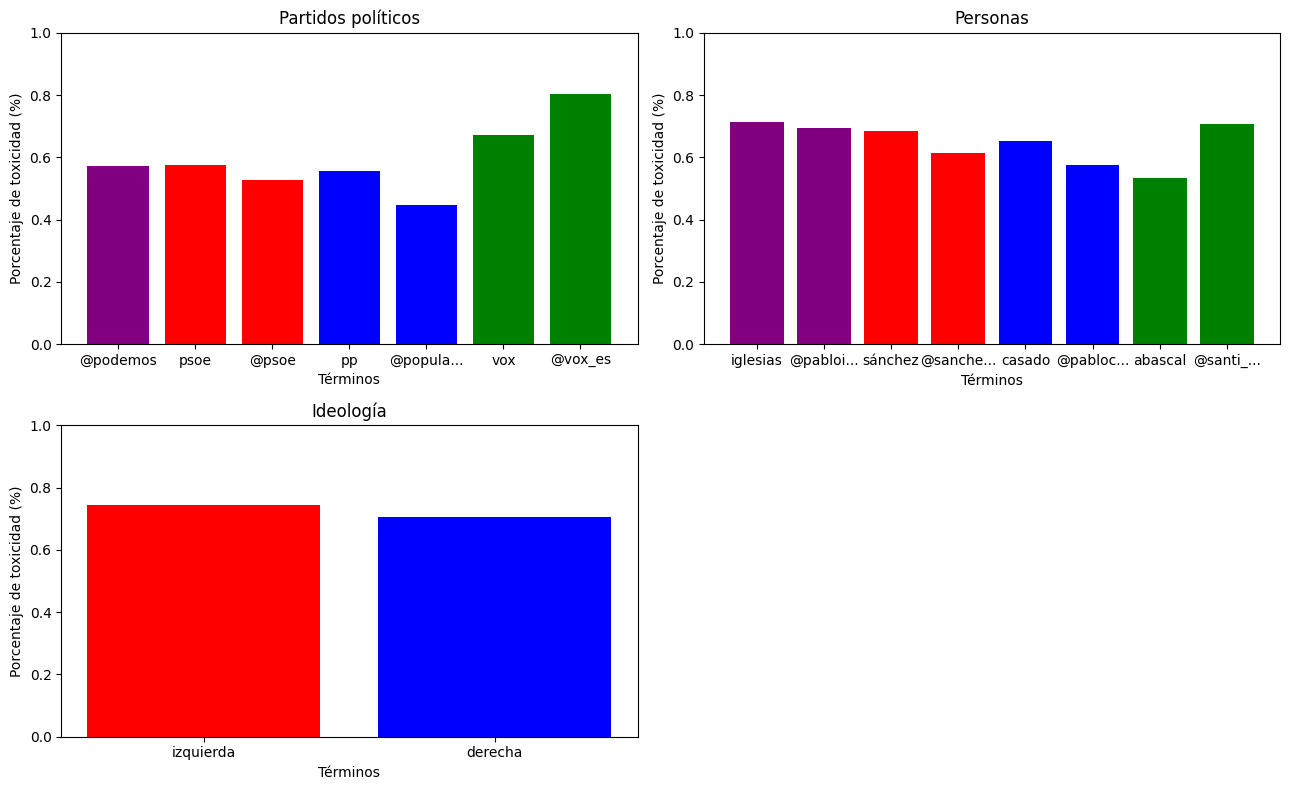

In [30]:
# Define the three plots
plots = {
    'Partidos políticos': {
        'terms': ['@podemos', 'psoe', '@psoe', 'pp', '@populares', 'vox', '@vox_es'],
        'colors':  ['purple', 'red', 'red', 'blue', 'blue', 'green', 'green']
    },
    'Personas': {
        'terms': ['iglesias', '@pabloiglesias', 'sánchez', '@sanchezcastejon', 'casado', '@pablocasado', 'abascal', '@santi_abascal'],
        'colors':  ['purple', 'purple', 'red', 'red', 'blue', 'blue', 'green', 'green']
    },
    'Ideología': {
        'terms': ['izquierda', 'derecha'],
        'colors':  ['red', 'blue']
    },
}

# Make a 2x2 grid
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(13, 8))
for i, (label, values) in enumerate(plots.items()):
    toxicity_ratio = [global_frequencies_train[TOXIC][term] for term in values['terms']]
    # Truncate long names to avoid visual overflow on the plots
    term_names = [name if len(name) < 10 else f"{name[:10-len('...')]}..." for name in values['terms']]

    ax = axes[i // 2, i % 2]
    ax.bar(term_names, toxicity_ratio, color=values['colors'])
    ax.set_xlabel('Términos')
    ax.set_ylabel('Porcentaje de toxicidad (%)')
    ax.set_title(label)
    ax.set_ylim(0, 1)

# Hide the fourth axis
axes[1, 1].axis('off')

# Show plots
plt.tight_layout()
plt.show()

He considerado a los cuatro principales partidos políticos a nivel nacional y sus líderes políticos de la época de la pandemia:
- Pablo Iglesias (Podemos)
- Pedro Sánchez (PSOE)
- Pablo Casado (PP)
- Santiago Abascal (Vox)

Ni Yolanda Díaz ni Feijóo son figuras políticas relevantes en estos datos de entrenamiento.

En cuanto a los resultados, se puede observar que:
- <u>La toxicidad está más centrada en ataques hacia los políticos que hacia los propios partidos</u>.
- A nivel de partido, la toxicidad se concentra alrededor de Vox, como habíamos visto previamente.




###Ejemplos de mensajes tóxicos

In [31]:
import re
from IPython.display import display, HTML

In [32]:
# Show examples of toxic messages in a visual way (using material design cards)
# First, define the card style

style = """
<style>
.material-card {
    box-shadow: 0 4px 8px 0 rgba(0,0,0,0.2);
    transition: 0.3s;
    border-radius: 10px;
    padding: 15px;
    margin-bottom: 20px;
    background-color: #fff;
}

.card-title {
    color: #06c2c2;
    font-size: 18px;
    margin-bottom: 10px;
    font-weight: bold;
}

.card-content {
    color: #333;
}
</style>
"""
cards_html = ""

# Select a list of TOP10 toxic words according to our analysis
most_toxic_words = ['miserable', 'vergüenza', 'progre', 'golpista', 'sectario',
                    'ruina', 'separatista', 'comunista', 'mafia', 'miseria']

for word in most_toxic_words:
    # Filter the toxic (label 1) rows that contain such word
    filtered_rows = df_train_val[(df_train_val['text'].str.contains(
        fr"\b{word}\b", na=False, regex=True)) & (df_train_val['label'] == 1)]

    if not filtered_rows.empty:  # If there's some match
        example_text = filtered_rows['text'].iloc[0]

        # Highlight the matching word (independently of the casing)
        bolded_word = fr"<b>{word}</b>"
        example_text_bolded = re.sub(fr"\b{word}\b", bolded_word, example_text,
                                     flags=re.IGNORECASE)

        # Append the toxic message to the card
        cards_html += f"""
        <div class="material-card">
            <div class="card-title">{word.upper()}</div>
            <div class="card-content">{example_text_bolded}</div>
        </div>
        """
    else:  # Otherwise, show a standard message
        cards_html += f"""
        <div class="material-card">
            <div class="card-title">{word.upper()}</div>
            <div class="card-content">No se encontraron coincidencias.</div>
        </div>
        """

# Combine HTML and CSS segments and display the cards
display(HTML(style + cards_html))

Los ejemplos muestran mensajes de ambas corrientes políticas, aunque es cierto que la corriente conservadora es mayoritaria (7 de 10). Independientemente de la orientación política, **la gran mayoría de mensajes parecen estar relacionados con Vox o han asimilado su discurso**, por lo que, como veníamos viendo, este partido parece ser la fuente principal de toxicidad en Twitter en el ciclo político actual:
- <u>Mensajes de Vox o apoyo de sus simpatizantes (mención directa)</u>: "vergüenza", "progre", "separatista", "comunista", "mafia".
- <u>Ataques a Vox</u>: "golpista".
- <u>Mensajes con el mismo discurso que Vox</u> (_derecha alternativa_): "sectario", "ruina".

Se trata de un <u>discurso muy fácilmente identificable</u> (polarizante y simplista [creación de bandos enfrentados e irreconciliables de buenos y malos]) <u>que abusa de descalificativos con marcado corte político que son además muy característicos</u> (progre, comunista, etc) <u>y con "enemigos" claros</u> (los partidos de "izquierdas", los nacionalismos periféricos [en el caso particular de España], los inmigrantes musulmanes y el feminismo).

#Preprocesado de los datos

Ahora vamos a proceder a hacer un **simple preprocesado** de los datos de entrenamiento y _test_. La limpieza llevada a cabo previamente para solucionar los problemas de decodificación se puede considerar también parte del preprocesado, pero se realizó con anterioridad para facilitar el análisis del contenido semántico de los datos. Este preprocesado consiste en las siguientes acciones:
- <u>Sustitución de los saltos de línea</u> (\n) <u>por espacios</u>.
- <u>Eliminación de todos los emojis</u>. A pesar de que estos sí que tienen significado semántico, no es común que aparezcan en los vocabularios de los modelos de NLP (tal y como sucede en el modelo que emplearé para esta tarea), lo cual no hace otra cosa que añadir ruido en forma de tokens \<unk>.
- <u>Eliminación de las URL de Twitter que empiezan por "https://t.co/"</u>. Se trata de URL sin ningún tipo de información semántica (no contienen palabras).

Me he ayudado de la librería cleantext para los dos primeros puntos.

In [33]:
from cleantext import clean
from toxicity_analysis.utils.constants import TWITTER_REGEX

In [34]:
text_columns = [TEXT, ENGLISH, FRENCH]  # Target columns (og text and their translations)

# Define cleantext preprocessing function.
# Ensure that undesired default parameters are set to False
remove_line_breaks_emojis = lambda text: clean(text, fix_unicode=False, to_ascii=False, lower=False,
                                               no_line_breaks=True, strip_lines=False, no_emoji=True) if text is not NA else NA

# Create new train/test DataFrames with the preprocessed texts
# to maintain their "raw" versions separated
df_train_val_prepro, df_test_prepro = df_train_val.copy(), df_test.copy()

for column in text_columns:  # Apply the preprocessing
    df_train_val_prepro[column] = df_train_val_prepro[column].str.replace(TWITTER_REGEX, '', regex=True).apply(remove_line_breaks_emojis).astype('string')
    df_test_prepro[column] = df_test_prepro[column].str.replace(TWITTER_REGEX, '', regex=True).apply(remove_line_breaks_emojis).astype('string')

In [35]:
style_dataframe(df_train_val_prepro)

id,text,label,origin,id-type,english,french
https://www.elplural.com/politica/espana/polemica-respuesta-espinosa-monteros-marlaska-despedida-julio-anguita-no-respetaron-distancias_240104102,"Durante su intervención, el vicesecretario de Vox también ha dejado patente la crisis a la que se enfrenta la derecha después de que Ciudadanos apoyase la pasada prórroga del estado de alarma, como se espera que también apoye la que se debate mañana.",0,news-articles,url,"Espinosa de los Monteros has compared both protests to the funeral of the former leader of IU and former mayor of Córdoba, Julio Anguita, who passed away on May 16th due to a cardiac arrest.","Espinosa de los Monteros a comparé les deux manifestations avec les funérailles de l'ancien dirigeant d'IU et ancien maire de Cordoue, Julio Anguita, décédé le 16 mai dernier d'un arrêt cardiaque."
1.271010900259078e+18,"Nueva manipulación a la mujer de la @rfef, dónde se quedó la igualdad ante la Ley del art 14 de la Constitución @VOX_Congreso seguirá luchando.",1,twitter,twitterId,"New manipulation of the woman from @rfef, where is the equality before the Law of article 14 of the Constitution @VOX_Congreso will continue fighting.","Nouvelle manipulation de la femme de la @rfef, où est passée l'égalité devant la loi de l'article 14 de la Constitution @VOX_Congreso continuera à se battre."
1.2986035925013957e+18,SOLIDARIDAD con los 500 trabajadores de Acciona que se enfrentan a un ERE. El gobierno más preocupado de sus políticas progres que de crear un tejido industrial fuerte. Los sindicatos cómplices preocupados por agradar al gobierno.,1,twitter,twitterId,SOLIDARITY with the 500 Acciona workers facing a redundancy plan. The government more concerned about its progressive policies than creating a strong industrial fabric. The complicit unions worried about pleasing the government.,SOLIDARITÉ avec les 500 travailleurs d'Acciona qui font face à un ERE. Le gouvernement plus préoccupé par ses politiques progressistes que par la création d'un tissu industriel solide. Les syndicats complices préoccupés par plaire au gouvernement.
1.2811132626507776e+18,"#BuenosDías #FelizJueves Mañana nuestra candidata a la Xunta @Beatriz_Pino_ , estará acompañada de @Tonicanto1 y @GuillermoDiazCs en #SantiagodeCompostela #StopNacionalismo Alameda 12:30h ¡Te esperamos! #MoitoQueGañar",0,twitter,twitterId,"#GoodMorning #HappyThursday Tomorrow our candidate for the Xunta @Beatriz_Pino_, will be accompanied by @Tonicanto1 and @GuillermoDiazCs in #SantiagodeCompostela #StopNationalism Alameda 12:30pm We'll be waiting for you! #MuchToGain","#Bonjour #JoyeuxJeudi Demain notre candidate à la Xunta @Beatriz_Pino_, sera accompagnée de @Tonicanto1 et @GuillermoDiazCs à #SantiagodeCompostela #StopNacionalismo Alameda 12h30 Nous t'attendons ! #BeaucoupAGagner"
1.465632198984405e+18,"Porros o educación gratuita. Adoctrinamiento progre o educación gratuita y exigente. Fracaso escolar o educación gratuita, exigente y de calidad. Juventud sumisa o juventud con futuro. Cuestión de prioridades, cuestión de agendas.",1,twitter,twitterId,"Joints or free education. Progressive indoctrination or free and demanding education. School failure or free, demanding and quality education. Submissive youth or youth with a future. A matter of priorities, a matter of agendas.","Joints ou éducation gratuite. Endoctrinement progressiste ou éducation gratuite et exigeante. Échec scolaire ou éducation gratuite, exigeante et de qualité. Jeunesse soumise ou jeunesse avec un avenir. Question de priorités, question d'agendas."


In [36]:
style_dataframe(df_test_prepro)

id,text,label,origin,id-type,english,french
https://www.newtral.es/voto-internet-elecciones-espana-por-que-no-hay/20230320/,El ensayo con los españoles en el extranjero sería la ruta del voto por internet,0,news-articles,url,"The common denominator in the experts' opinion is that, for the moment, neither Spain nor the other EU countries need internet voting, because, despite the intentions that exist, the results from neighboring countries are not encouraging.","Le dénominateur commun dans l'opinion des experts est que, pour le moment, ni l'Espagne ni les autres pays de l'UE n'ont besoin du vote par internet, car malgré les intentions qui existent, les résultats des voisins ne sont pas encourageants."
1.4439912260432282e+18,Hoy a las 20:20 os espero en el programa @24horas_rne analizando la actualidad nacional. Podéis escucharlo en vuestras o en,0,twitter,twitterId,Today at 20:20 I'll be waiting for you on the program @24horas_rne analyzing the national news. You can listen to it on your or at,"Aujourd'hui à 20h20, je vous attends dans l'émission @24horas_rne pour analyser l'actualité nationale. Vous pouvez l'écouter sur vos ou sur"
https://maldita.es/feminismo/20230307/laboral-brecha-genero-espana/,"Además de la diferencia de salarios, hay una serie de variables que determinan las distintas brechas laborales que segregan a mujeres y hombres.",0,news-articles,url,"""Worked hours are a homogeneous data that can be aggregated, while workdays are not,"" points out Belén Medina.","""Les heures travaillées sont une donnée homogène qui peut être agrégée tandis que les journées ne le sont pas"", souligne Belén Medina."
https://www.alertadigital.com/2023/03/11/dieciocho-anos-despues-del-11-m-entendemos-mucho-mas-de-atentados-de-falsa-bandera-y-otros-asuntos-de-las-cloacas-las-preguntas-sobre-la-masacre-que-nunca-fueron-respondidas/,"¿Por qué si se grabó en Gijón, aparece años después en otro lugar?",0,news-articles,url,We didn't understand it at that moment.,Nous ne l'avons pas compris à ce moment-là.
1.3853418377209242e+18,Ha sido un placer entregar a @jonkortajarena su premio #MadBlue por su labor de defensa del medioambiente. Y disfrutar del concierto de @LucasVidalmusic después de sus dos Goyas. Enhorabuena a Luis Prieto y a todos los #Premios5Océanos.,0,twitter,twitterId,It has been a pleasure to present @jonkortajarena with his #MadBlue award for his work in environmental defense. And to enjoy @LucasVidalmusic's concert after his two Goyas. Congratulations to Luis Prieto and all the #Premios5Océanos.,Cela a été un plaisir de remettre à @jonkortajarena son prix #MadBlue pour son travail de défense de l'environnement. Et de profiter du concert de @LucasVidalmusic après ses deux Goyas. Félicitations à Luis Prieto et à tous les #Premios5Océanos.


Comprobamos que el preprocesado ha funcionado correctamente.

#Creación de los datasets de _train_, _validation_ y _test_

A pesar de que la cantidad de datos de entrenamiento es más bien limitada (11.000 filas; 30.919 textos en total si contamos las traducciones a inglés y francés que no son _missing values_), **siempre es recomendable reservarse un _split_ de validación para asegurarse durante el entrenamiento que nuestro modelo está generalizando correctamente y detectar cuándo se produce el _overfitting_**.

Dicho _split_ de validación se obtiene de forma aleatoria de los datos de entrenamiento antes de mezclar todos los textos independientemente del idioma, asegurándonos de que textos con el mismo contenido semántico no se mezclan en distintos _splits_ (_data leakage_). Tras esto, procedemos a crear una entrada del dataset por texto siempre que este no constituya un _missing value_. Los dataset tienen por tanto sólo las columnas "text" y "label".

Se definen también <u>datasets segmentados por idioma</u> para realizar luego pruebas de rendimiento por idioma.

In [37]:
from sklearn.model_selection import train_test_split
from toxicity_analysis.utils.constants import COLUMN_TO_LANG, TRAIN, VAL, TEST

In [38]:
# Split before merging languages to avoid any data leakage
# Validation size: 10% of the training data
df_train_prepro, df_val_prepro = train_test_split(df_train_val_prepro, test_size=0.1, random_state=0, shuffle=True)

# As we want to achieve a language-agnostic model, we create a unique "text"
# variable with the contents of the previous "text", "english" and "french" variables,
# ignoring all missing values ('single_language_datasets').

# In both cases (all/single languages), they're defined as dictionaries
# whose keys are the name of the data split: train, val, test
datasets, single_language_datasets = {}, {}

# Iterate over each data split
for df_prepro, dataset_name in zip((df_train_prepro, df_val_prepro, df_test_prepro), (TRAIN, VAL, TEST)):

  # Single-language datasets are two-level dictionaries -> data split -> language
  single_language_datasets[dataset_name] = {COLUMN_TO_LANG[language]:
                                            df_prepro[[language, LABEL]].copy().dropna().rename(columns={language: TEXT})
                                            for language in text_columns}

  # For simplification, all-language data splits are obtained via single-language datasets concatenation
  datasets[dataset_name] = pd.concat(single_language_datasets[dataset_name].values(), axis=0, ignore_index=True)

  # [Sanity check] Make sure that data types of both variables is correct
  assert datasets[dataset_name][LABEL].dtype == 'uint8', f"Label dtype was expected to be uint8. Got {datasets[dataset_name][LABEL].dtype}"
  assert datasets[dataset_name][TEXT].dtype == 'string', f"Text dtype was expected to be string. Got {datasets[dataset_name][TEXT].dtype}"


# Create independent variables for each data split
train_dataset, val_dataset, test_dataset = datasets[TRAIN], datasets[VAL], datasets[TEST]

assert train_dataset.shape[-1] == val_dataset.shape[-1] == test_dataset.shape[-1] == 2, f"All datasets must have 'text' and 'label' columns only."

Comprobamos que el formato de los diferentes _splits_ es el correcto y que su tamaño es el esperado (27.853 + 3.066 = 30.919 OK).

In [39]:
style_dataframe(train_dataset)

text,label
"La verdad, más bien, es que el despliegue empresarial de los españoles por el mundo se ha producido en la mayoría de los casos a pesar del Gobierno, desde luego del actual, pero también de los anteriores, muy diferentes de otros legendarios en este aspecto como el estadounidense, el británico o el francés.",1
"Valga el símil para el caso de Celia Mayer, que ha pasado de tener una concejalías importante del Ayuntamiento de Madrid, a cargar con la responsabilidad de otra de nueva creación, la de Igualdad.",0
Mañana los españoles estamos llamados a colapsar las calles con nuestros coches y banderas de España para lograr que caiga el Gobierno totalitario y criminal. ¡Obliguemos a la mafia a dimitir y recuperemos España! #12OALaCalle,1
De él y de los jugadores espero a partir de ahora que hablen solo en el campo.,0
Precisamente.,0


In [40]:
print(train_dataset.shape)

(27853, 2)


In [41]:
style_dataframe(val_dataset)

text,label
"De verdad No se puede ser mas inútil, desacertado y el tacto por donde amargan los pepinos... que vergüenza!!! Ánimo Emilio, cuanto analfabeto hay que aguantar!!! #MotivosParaLaMoción #LevantandoEspanaConVox #ChicasVox52",1
"112 años del nacimiento de #SalvadorAllende Lo recordamos junto al valiente pueblo chileno, alzado aun hoy contra un Gobierno indigno y represor Que retornen los libros, las canciones, y q renazca el pueblo de su ruina, como cantaba Pablo Milanés #ChileDesperto #AllendeVive",1
Es infame @sanchezcastejon y @abalosmeco de rodillas ante los asesinos de ETA y humillando a las victimas. @_AVT_ @GPPopular @populares.,1
Ni las arañas tienen tan atrofiado el instinto materno. El feminismo es una ideología demente y un callejón sin salida.,1
"En concreto, durante su primer día en Bolsa los títulos subieron más de un 20%, lo que permitió a los grandes fondos de inversión ganar unos 800 millones de euros en una sola jornada.",0


In [42]:
print(val_dataset.shape)

(3066, 2)


In [43]:
style_dataframe(test_dataset)

text,label
El ensayo con los españoles en el extranjero sería la ruta del voto por internet,0
Hoy a las 20:20 os espero en el programa @24horas_rne analizando la actualidad nacional. Podéis escucharlo en vuestras o en,0
"Además de la diferencia de salarios, hay una serie de variables que determinan las distintas brechas laborales que segregan a mujeres y hombres.",0
"¿Por qué si se grabó en Gijón, aparece años después en otro lugar?",0
Ha sido un placer entregar a @jonkortajarena su premio #MadBlue por su labor de defensa del medioambiente. Y disfrutar del concierto de @LucasVidalmusic después de sus dos Goyas. Enhorabuena a Luis Prieto y a todos los #Premios5Océanos.,0


In [44]:
print(test_dataset.shape)

(14977, 2)


## Evaluación inicial del modelo preentrenado

Antes de definir la _pipeline_ de entrenamiento de nuestro modelo preentrenado, vamos a probar <u>qué tal funciona el modelo elegido directamente en los datos de validación para cada idioma</u>. No utilizo los datos de _test_ porque estos se deben reservar para la evaluación final ni tampoco los datos de entrenamiento porque es a los que se ajustará el modelo en el proceso de _fine-tuning_.

El modelo elegido ha sido **lxyuan/distilbert-base-multilingual-cased-sentiments-student** (HuggingFace). ¿Por qué?
- Al tratarse de una tarea de clasificación, no necesitamos un modelo que posea un _decoder_ (no vamos a generar texto, sólo necesitamos un modelo que sea capaz de capturar la información de los textos), por lo que un modelo <u>_encoder-only_</u> es la mejor solución.
- Actualmente, el modelo _encoder-only_ de referencia (SoTA) es <u>BERT</u>.
- Como tenemos una cantidad de datos de entrenamiento muy reducida y además la cantidad de cómputo gratuita que ofrece Google Colab es bastante limitada, seleccionamos la <u>versión más ligera que existe actualmente de BERT: DistilBERT</u> (135M de parámetros).
- Es mucho más prioritario que <u>el modelo comprenda tanto el español, como el inglés y el francés</u> a que sepa realizar la tarea de detección de toxicidad; ya que esta se puede adaptar a partir de una similar mucho más fácilmente que tener que entrenar los _embeddings_.
- Es aquí donde llegamos a la elección de distilbert-base-multilingual-cased-sentiments-student, ya que (1) es un modelo DistilBERT (2) comprende 12 idiomas (entre ellos español, inglés y francés) (3) fue entrenado para la tarea de _sentiment analysis_, una tarea de clasificación que guarda bastantes similitudes con la detección de toxicidad.

Lo he implementado todo en <u>PyTorch</u> por ser la librería nativa de HuggingFace.

In [45]:
import torch
from torch.utils.data import DataLoader
from warnings import warn

from toxicity_analysis.utils.constants import MODEL_NAME, MODEL_MAX_LENGTH
from transformers import DistilBertForSequenceClassification, DistilBertTokenizer

# Warn when GPU is not available (pretty common)
if not torch.cuda.is_available():
    warn("Running PyTorch in CPU")
else:  # Check CUDA config (if GPU is available)
  !nvidia-smi

device = torch.device("cpu" if not torch.cuda.is_available() else "cuda")

Wed Nov 29 02:01:19 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P0    23W / 300W |      2MiB / 16384MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [46]:
# Function to tokenize every text chain that arrives to the model
# within a batch (collate_fn of the DataLoader that generates the batches)
def tokenize_batch(batch):
    return tokenizer(batch, padding=True, truncation=True, max_length=MODEL_MAX_LENGTH, return_tensors="pt")

model_name = MODEL_NAME
batch_size = 64

# Load model and tokenizer
model = DistilBertForSequenceClassification.from_pretrained(model_name)
model.to(device)
tokenizer = DistilBertTokenizer.from_pretrained(model_name)

# 'sort_val_set_by_lang' is a dictionary that store each (text, label) pair
# filtered by their language. The items are ordered by texts' length
# in ascending order for a faster inference
sort_val_set_by_lang = {lang: dataset.copy().sort_values(by=TEXT, key=lambda x: x.str.len())
                                     for lang, dataset in single_language_datasets[VAL].items()}

# Store model's predictions by language (same structure as 'sort_val_set_by_lang')
predictions_by_lang = {lang: [] for lang in single_language_datasets[VAL]}

with torch.no_grad():
    for lang, lang_set in sort_val_set_by_lang.items():  # Iterate over each language
        # Create a DataLoader to manage correctly the batching
        data_loader = DataLoader(lang_set[TEXT].tolist(), batch_size=batch_size, collate_fn=tokenize_batch)
        # Iterate over each batch (TQDM to see progress -> it takes time)
        for batch in tqdm(data_loader, desc=f"Processing results ({lang.title()})"):
            batch = batch.to(device)
            logits = model(**batch).logits  # Get model's output
            # Apply softmax function to get the most probable output
            scores = torch.nn.functional.softmax(logits, dim=1).tolist()
            predictions_by_lang[lang].extend(scores)  # Store prediction


config.json:   0%|          | 0.00/759 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/541M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/373 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.92M [00:00<?, ?B/s]

Processing results (French): 100%|██████████| 16/16 [00:02<00:00,  7.97it/s]


In [47]:
import numpy as np
from scipy.stats import pearsonr

from toxicity_analysis.utils.analysis_utils import show_toxicity_vs_sentiment_confusion_matrix

A continuación se muestra una **matriz de confusión** para cada idioma con los resultados de la inferencia del modelo según el _label_ del texto de entrada. Así podremos estimar el punto de partida del modelo.

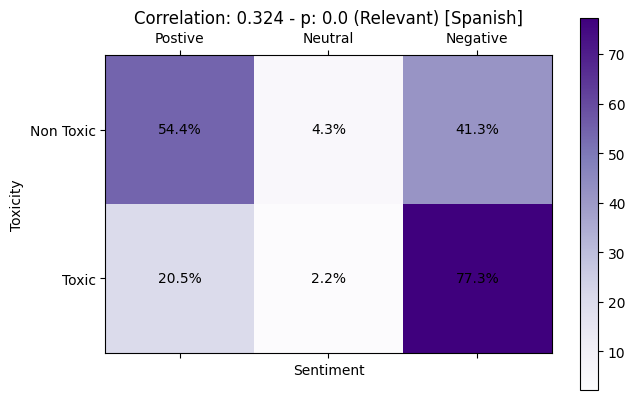

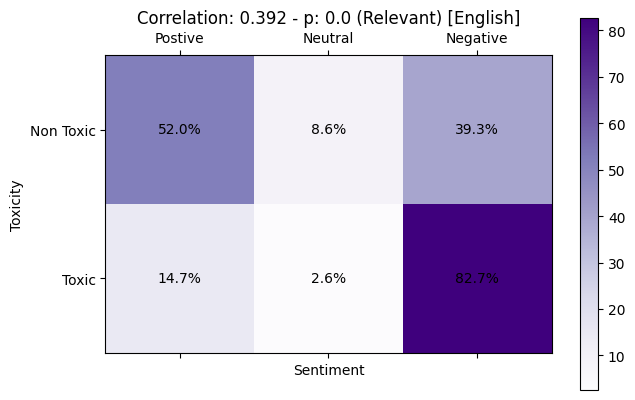

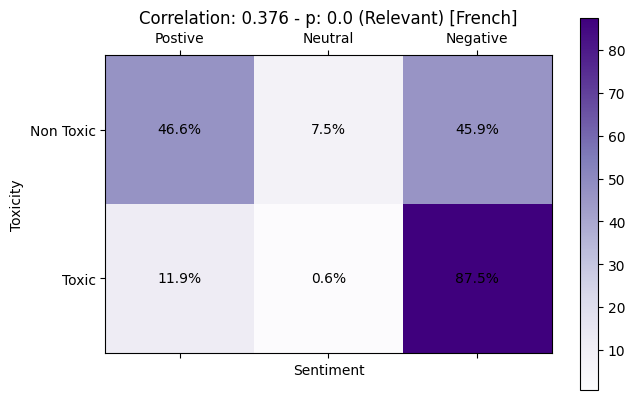

In [48]:
 # Iterate over each validation set entry
for lang, toxicity_dataset in sort_val_set_by_lang.items():
    toxicity_labels = list(toxicity_dataset[LABEL])  # Get entry labels
    # Get sentiment analysis model's predictions (both follow the same order)
    sentiment_labels = list(np.argmax(predictions_by_lang[lang], axis=1))
    assert len(toxicity_labels) == len(sentiment_labels), f"The number of inputs and predictions must be the same"

    # Calculate the Pearson correlation to test the strength in the relationship
    # between both variables. Our hypothesis is that there is a positive relation,
    # this is, that toxicity is related to negative sentiments
    pearson, hipothesis_p_value = pearsonr(x=toxicity_labels, y=sentiment_labels, alternative='greater')

    # Define the title of the plot
    p_explanation = 'Relevant' if hipothesis_p_value < 0.001 else 'Irrelevant'
    pearson_explanation = f"Correlation: {round(pearson, ndigits=3)} - p: {round(hipothesis_p_value, ndigits=5)} ({p_explanation})"

    # Plot the result
    show_toxicity_vs_sentiment_confusion_matrix(toxicity_labels=toxicity_labels,
                                                sentiment_labels=sentiment_labels,
                                                title=f"{pearson_explanation} [{lang.title()}]")

Los resultados muestran que existe una **correlación moderada entre las variables de toxicidad y análisis de sentimientos**, lo cual es el punto de partida que buscábamos cuando se elegió este modelo:
- Parece ser que el modelo <u>funciona bastante mejor en los idiomas inglés y francés que en español</u>. En ambos casos, clasifica los textos tóxicos con sentimientos negativos en +80% de los casos; mientras que en español desciende al 77%.
- Se ve claramente que <u>el reto se va a encontrar en los textos no tóxicos</u>, ya que el modelo lo clasifica 50/50 (aprox) como positivos o negativos. Al tener los textos no tóxicos principalmente un enfoque informativo, parece ser que influye bastante el contenido mismo de la noticia.

# Entrenamiento del modelo

El entrenamiento mediante _fine-tuning_ del ya mencionado modelo lxyuan/distilbert-base-multilingual-cased-sentiments-student consta de las siguientes características [para mayor detalle de la implementación, mirar los comentarios]
:
- Se le pasan los datos en <u>batches de 64</u> (máximo permitido por los recursos disponibles).
- Dichos datos se <u>aleatorizan al inicio de cada _epoch_</u>.
- Una _epoch_ consiste de una sección de entrenamiento y otra de validación. El <u>criterio de parada se define según la _loss_ de los datos de validación</u>, pero se _trackea_ tanto la precisión como la _loss_ de ambos dataset en tiempo real (para cada _training step_).
- Se guarda el histórico de ambas métricas así como el mejor valor hasta la fecha para ambos _splits_ en un fichero JSON y también un <u>_checkpoint_ por _epoch_</u> (tanto pesos como modelo completo). Ambos los guardo en Google Drive para evitar perder estos ficheros debido a algún reinicio de sesión inesperado.
- El <u>optimizador</u> elegido ha sido <u>AdamW</u>, que es la versión regularizada (permite reducir el _overfitting_) del optimizador más comúnmente empleado entre los adaptativos, muy útiles por actualizar dinámicamente la _learning rate_ sin mayor indicación que el valor inicial (5e-5 en este caso, muy pequeña por la propia naturaleza del _fine-tuning_).
- La <u>función de _loss_</u> empleada es la <u>_logistic regression_</u> con pesos inversamente proporcionales al balanceo de clases. Se trata de la función comúnmente utilizada al enfrentarse a una tarea de clasificación binaria.
- Se ha ajustado el <u>número de clases</u> a predecir por el modelo a <u>dos</u>.
- <u>Se ha congelado la capa de _embeddings_ del modelo en todos los experimentos</u>, ya que no nos interesa que modifique el significado de los tokens de un vocabulario tan extenso cuando tenemos un dataset tan reducido (generalizaría peor).
- Debido a los <u>problemas de _overfitting_</u>, se han realizado distintos experimentos <u>congelando diversos bloques de Transformer para reducir el número de parámetros que debe optimizar</u> (y por tanto la complejidad del modelo).

**Creación del objeto Dataset**

In [49]:
from torch.utils.data import Dataset

In [50]:
# Define the Dataset object
class ToxicityDataset(Dataset):

    def __init__(self, dataframe, tokenizer, max_length=MODEL_MAX_LENGTH):
        self._dataframe = dataframe  # Data split with "text" and "label" columns
        self.max_length = max_length  # Maximum model lenght (tokens)
        self.input_ids, self.attention_mask = [], []

        # Tokenize at __init__ to save time at training
        for text in dataframe[TEXT]:
            encoding = tokenizer.encode_plus(text, add_special_tokens=True, max_length=self.max_length,
                                               padding='max_length', truncation=True, return_tensors='pt')

            # Encoder-only models don't require decoder inputs (only input_ids and attention_masks)
            input_ids, attention_masks = encoding['input_ids'][0], encoding['attention_mask'][0]
            self.input_ids.append(input_ids)
            self.attention_mask.append(attention_masks)

        # Get labels of each entry for the loss function computation
        self.labels = torch.tensor(dataframe[LABEL], dtype=torch.int64)

        assert len(self.input_ids) == len(self.attention_mask) == len(self.labels)\
               == len(self._dataframe), "Lengths mismatch."

    def __len__(self):
        # Needed for batching and epoch estimations
        return len(self._dataframe)

    def __getitem__(self, idx):
        assert idx <= len(self._dataframe), f"Trying to access idx {idx} in a dataset of size {len(self._dataframe)}"

        # In HuggingFace models, inputs are provided as dictionaries
        return {
            'input_ids': self.input_ids[idx],
            'attention_mask': self.attention_mask[idx],
            'labels': self.labels[idx]
        }

**Definición del proceso de entrenamiento y evaluación para cada _epoch_**

In [51]:
# Define the training / validation process of each epoch (it has two modes)
def process_epoch(model, data_loader, loss_fn, device,
                  mode='train', optimizer=None, scheduler=None):

    assert mode in ('train', 'eval'), f"Mode must be 'train' or 'eval', got {mode} mode."

    # Set the correct mode in the model, since during evaluation we don't need
    # as much resources as during training
    if mode == 'train':
        assert optimizer is not None and scheduler is not None, f"Missing optimizer and/or scheduler during training."
        model.train()
    else:
        model.eval()

    losses, corrects = [], 0  # Loss and accuracy metrics

    # Using TQDM as a 'with' instead of a 'for' to see the progress of
    # loss and accuracy metrics dynamically during training and evaluation
    with tqdm(total=len(data_loader), desc=f"{mode.title()} progress") as progress:
        for i, d in enumerate(data_loader):  # For each batch

            # Get inputs
            input_ids, labels = d["input_ids"].to(device), d["labels"].to(device)
            attention_masks = d["attention_mask"].to(device)

            # Set no_grad when evaluating the model (don't compute gradients)
            with torch.set_grad_enabled(mode=='train'):
                if mode == 'train':
                    outputs = model(input_ids=input_ids, attention_mask=attention_masks, labels=labels)
                else:
                    outputs = model(input_ids=input_ids, attention_mask=attention_masks)

                # Compute loss for this batch
                loss = loss_fn(outputs.logits, labels)
                losses.append(loss.item())

                # Compute accuracy for this batch
                corrects_count = torch.sum(torch.argmax(outputs.logits, dim=1) == labels)
                corrects += corrects_count.item()

                # Update loss optimizer and learning rate scheduler
                if mode == 'train':
                    optimizer.zero_grad()
                    loss.backward()  # Backpropagation
                    optimizer.step()
                    scheduler.step()

                progress.update(1)  # Update TQDM's loss and accuracy metrics
                progress.set_description(f"{mode.title()}. Loss: {round(sum(losses)/len(losses), ndigits=4)}."\
                                         f" Acc: {round((corrects/((i+1)*data_loader.batch_size))*100, ndigits=3)}%")

    # Get final mean loss and accuracy metrics for this epoch
    accuracy = corrects / len(data_loader.dataset)
    mean_loss = sum(losses) / len(losses)

    return accuracy, mean_loss

**Parametrización del entrenamiento y definición de los diferentes experimentos**

In [52]:
import math
import json

from sklearn.utils.class_weight import compute_class_weight
from transformers import get_linear_schedule_with_warmup

from torch.utils.data import Sampler
from torch.optim import AdamW

In [53]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device == "cpu":
    warn("Running training in CPU")
else:
    # Empty the CUDA cache if using GPU
    torch.cuda.empty_cache()

# Batch size 32 is the maximum possible with *GPU* Colab resources
NUM_EPOCHS, BATCH_SIZE = 40, 64

tokenizer = DistilBertTokenizer.from_pretrained(model_name)

# Define train and validation datasets. Shuffle them at the beginning of each epoch
training_set = ToxicityDataset(dataframe=train_dataset, tokenizer=tokenizer)
train_loader = DataLoader(training_set, batch_size=BATCH_SIZE, shuffle=True)

validation_set = ToxicityDataset(dataframe=val_dataset, tokenizer=tokenizer)
validation_loader = DataLoader(validation_set, batch_size=BATCH_SIZE, shuffle=True)

In [54]:
from toxicity_analysis.utils.constants import CHECKPOINT_PATHS, ONLY_FREEZE_EMBEDDINGS, FREEZE_ALL_TRANSFORMER_LAYERS_EXCEPT_LAST, FREEZE_ALL_TRANSFORMER_LAYERS

# Since the model is big (135M) and the training data is scarce, the model tends
# to overfit fast (at the 3rd epoch usually). At the beginning, I only planned
# to freeze the embeddings layer (to not lose the broad knowledge of such
# a big vocabulary [+100K tokens] to a very specific scope of content and languages),
# but I also tested freezing different Transformer blocks to see if a reduced
# number of parameters to be trained would result in a better generalization

EXPERIMENT = FREEZE_ALL_TRANSFORMER_LAYERS

# We use different checkpoint paths for each one of the experiments
assert EXPERIMENT in CHECKPOINT_PATHS, f"Available experiments are {list(CHECKPOINT_PATHS.values())}. Got {EXPERIMENT}."
checkpoint_dir = CHECKPOINT_PATHS[EXPERIMENT]

full_model_path = os.path.join(checkpoint_dir, f"full_model_last.pt")
metrics_json_path = os.path.join(checkpoint_dir, "metrics.json")

if not os.path.isfile(full_model_path):  # Start fine-tuning (no checkpoint found)
    # Note that we changed the number of labels to two instead of three
    model = DistilBertForSequenceClassification.from_pretrained(
        model_name, num_labels=2, ignore_mismatched_sizes=True)
    last_metrics = {}
else:
    # If some checkpoint was found, load it on the target device
    model = torch.load(full_model_path, map_location=device)
    with open(metrics_json_path, "r") as f:
      last_metrics = json.load(f)

# Always freeze the embeddings (independently of the experiment)
for param in model.distilbert.embeddings.parameters():
    param.requires_grad = False

# Freeze also the Transfomer blocks if required
if EXPERIMENT in (FREEZE_ALL_TRANSFORMER_LAYERS_EXCEPT_LAST, FREEZE_ALL_TRANSFORMER_LAYERS):
    trans_layers = len(model.distilbert.transformer.layer)  # Get Transformer layers
    layers_to_freeze = 1 if EXPERIMENT == FREEZE_ALL_TRANSFORMER_LAYERS_EXCEPT_LAST else 0
    print(f"Freezed {trans_layers-layers_to_freeze} of {trans_layers} transformer layers")
    for i in range(trans_layers - layers_to_freeze):  # Freeze them
        for param in model.distilbert.transformer.layer[i].parameters():
            param.requires_grad = False

model = model.to(device)


Freezed 6 of 6 transformer layers


**Definición del _optimizer_ y _scheduler_**

In [68]:
# The optimizer is the stochastic algorithm that defines the direction
# of the model weights' updates during training in order to optimize the
# loss function and the scheduler defines the high-level progression of the
# learning rate parameter at every training step. This parameter is used
# by the optimizer to estimate how big these updates can be

# We use AdamW with a rather small starting learning rate because of
# doing a fine-tuning training. Why AdamW? Because (1) it's adaptive
# --the learning rate is updated automatically starting from an initial value
# and because (2) it applies L2 regularization (which reduces overfitting)
# It's also the common go-to optimizer and I didn't have much time for
# testing different options or hyperparameters
optimizer = AdamW(model.parameters(), lr=5e-5)

# To avoid problems when resuming checkpoint
for group in optimizer.param_groups:
    group.setdefault('initial_lr', group['lr'])

# Set warmup_steps=0 to start reducing the learning rate since the beginning
# and reduce the risk of overfitting
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0,
                                            num_training_steps=len(train_loader) * NUM_EPOCHS,
                                            last_epoch=last_metrics.get("epochs", 1))

# Weight the the loss function to assess class imbalance
class_weights = compute_class_weight('balanced', classes=[0, 1], y=train_dataset['label'].values)
weights = torch.tensor(class_weights, dtype=torch.float32, device=device)

# Cross Entropy (logistic regresstion) is the best
# loss function for *binary* classification
loss_fn = torch.nn.CrossEntropyLoss(weight=weights)

**Definición del proceso de entrenamiento, registro de métricas y condición de parada**

In [69]:
# Get history of loss and accuracy metrics
train_accs, train_losses = last_metrics.get('train_acc_hist', []), last_metrics.get('train_loss_hist', [])
val_accs, val_losses = last_metrics.get('val_acc_hist', []), last_metrics.get('val_loss_hist', [])
# Get best loss and accuracy to date, the condition to choose the final model
best_val_loss, best_val_loss_epoch = last_metrics.get('best_val_loss', float('inf')), last_metrics.get('best_val_loss_epoch', 0)
val_acc_at_best_loss = last_metrics.get("acc_at_best_loss", None)

SAVE_EVERY, EARLY_STOP_AT = 1, 10

# Iterate over a maximum number of epochs
for epoch in range(last_metrics.get("epochs", 0), NUM_EPOCHS):
    print(f"Epoch {epoch+1}/{NUM_EPOCHS}")

    # -- TRAIN SECTION --
    train_acc, train_loss = process_epoch(mode='train', model = model,
                                          data_loader = train_loader,
                                          loss_fn = loss_fn, optimizer = optimizer,
                                          device = device, scheduler = scheduler)

    train_accs.append(float(train_acc)), train_losses.append(float(train_loss))

    # -- VALIDATION SECTION --
    val_acc, val_loss = process_epoch(mode = 'eval', model = model,
                                      data_loader = validation_loader,
                                      loss_fn = loss_fn, device = device)

    val_accs.append(float(val_acc)), val_losses.append(float(val_loss))

    # The chosen model is the one that reduces the loss
    # on the validation data. These data are unseen by the model
    # and let us know if it's capable of generalizing
    if val_loss < best_val_loss:
      best_val_loss, best_val_loss_epoch = float(val_loss), epoch
      val_acc_at_best_loss = float(val_acc)
      # Save the best model (device-agnostic to ensure compatibility)
      model_to_save = model.to('cpu')
      torch.save(model_to_save.state_dict(), os.path.join(checkpoint_dir, f"best_model.pt"))
      model = model_to_save.to(device)

    # Trigger early stopping when validation loss hasn't improved
    # for "EARLY_STOP_AT" epochs
    elif best_val_loss_epoch + EARLY_STOP_AT < epoch:
      print(f"Early stopping triggered at epoch {epoch}")
      break

    # Save a model checkpoint every "SAVE_EVERY" epochs
    # We save both weights and full-model just in case
    if epoch % SAVE_EVERY == 0:
        model_to_save = model.to('cpu')
        torch.save(model.state_dict(), os.path.join(checkpoint_dir, f"model_last.pt"))
        torch.save(model, os.path.join(checkpoint_dir, f"full_model_last.pt"))
        model = model_to_save.to(device)

    # Save the metrics to a JSON file at every step
    with open(metrics_json_path, "w") as f:
        json.dump({
            "train_loss_hist": train_losses,
            "train_acc_hist": train_accs,
            "val_loss_hist": val_losses,
            "val_acc_hist": val_accs,
            "best_val_loss": best_val_loss,
            "best_val_loss_epoch": best_val_loss_epoch,
            "acc_at_best_loss": val_acc_at_best_loss,
            "epochs": epoch + 1 # There is one epoch completed at this point
        }, f)

Epoch 4/40


Eval. Loss: 0.3847. Acc: 83.789%: 100%|██████████| 48/48 [00:13<00:00,  3.44it/s]


Epoch 5/40


Eval. Loss: 0.375. Acc: 83.529%: 100%|██████████| 48/48 [00:14<00:00,  3.38it/s]


Epoch 6/40


Eval. Loss: 0.3666. Acc: 83.04%: 100%|██████████| 48/48 [00:14<00:00,  3.38it/s]


Epoch 7/40


Eval. Loss: 0.3656. Acc: 83.659%: 100%|██████████| 48/48 [00:14<00:00,  3.42it/s]


Epoch 8/40


Eval. Loss: 0.3613. Acc: 83.366%: 100%|██████████| 48/48 [00:14<00:00,  3.43it/s]


Epoch 9/40


Eval. Loss: 0.3644. Acc: 84.017%: 100%|██████████| 48/48 [00:14<00:00,  3.43it/s]


Epoch 10/40


Eval. Loss: 0.3638. Acc: 83.691%: 100%|██████████| 48/48 [00:14<00:00,  3.38it/s]


Epoch 11/40


Eval. Loss: 0.3624. Acc: 84.115%: 100%|██████████| 48/48 [00:14<00:00,  3.42it/s]


Epoch 12/40


Eval. Loss: 0.3694. Acc: 84.896%: 100%|██████████| 48/48 [00:14<00:00,  3.38it/s]


Epoch 13/40


Eval. Loss: 0.3536. Acc: 83.626%: 100%|██████████| 48/48 [00:14<00:00,  3.37it/s]


Epoch 14/40


Eval. Loss: 0.3637. Acc: 84.928%: 100%|██████████| 48/48 [00:14<00:00,  3.38it/s]


Epoch 15/40


Eval. Loss: 0.356. Acc: 84.505%: 100%|██████████| 48/48 [00:14<00:00,  3.42it/s]


Epoch 16/40


Eval. Loss: 0.3524. Acc: 84.277%: 100%|██████████| 48/48 [00:13<00:00,  3.43it/s]


Epoch 17/40


Eval. Loss: 0.3552. Acc: 84.863%: 100%|██████████| 48/48 [00:14<00:00,  3.33it/s]


Epoch 18/40


Eval. Loss: 0.3562. Acc: 84.831%: 100%|██████████| 48/48 [00:14<00:00,  3.43it/s]


Epoch 19/40


Eval. Loss: 0.3564. Acc: 84.928%: 100%|██████████| 48/48 [00:14<00:00,  3.42it/s]


Epoch 20/40


Eval. Loss: 0.3532. Acc: 84.961%: 100%|██████████| 48/48 [00:14<00:00,  3.37it/s]


Epoch 21/40


Eval. Loss: 0.353. Acc: 84.277%: 100%|██████████| 48/48 [00:14<00:00,  3.42it/s]


Epoch 22/40


Eval. Loss: 0.3452. Acc: 84.049%: 100%|██████████| 48/48 [00:13<00:00,  3.43it/s]


Epoch 23/40


Train. Loss: 0.3166. Acc: 86.053%:   6%|▌         | 27/436 [00:08<02:11,  3.11it/s]


KeyboardInterrupt: ignored

#Evaluación de los modelos candidatos y selección del modelo final

**Curvas de entrenamiento**

Experiment: only_freeze_embeddings


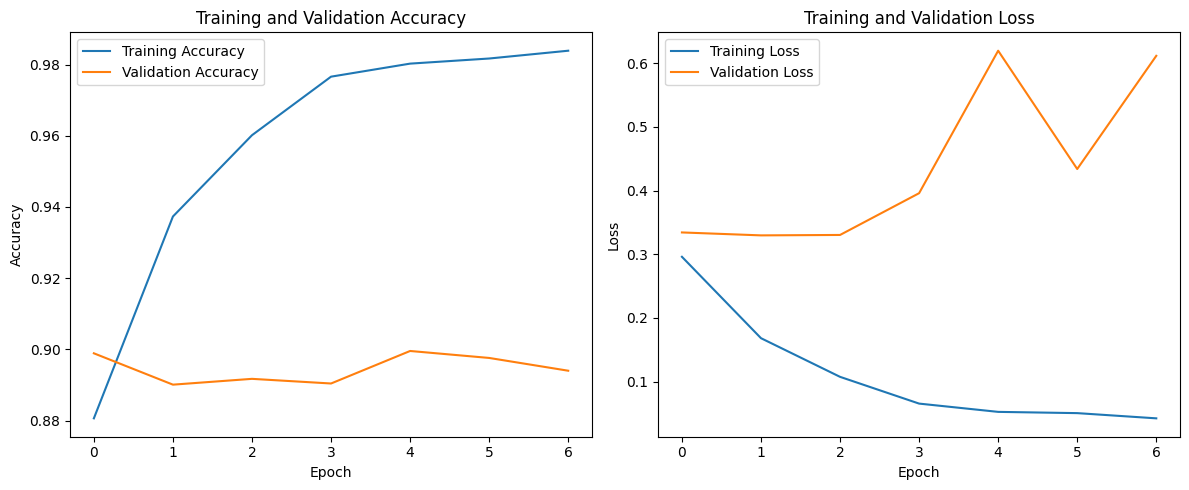

Experiment: freeze_all_transformer_layers_except_last


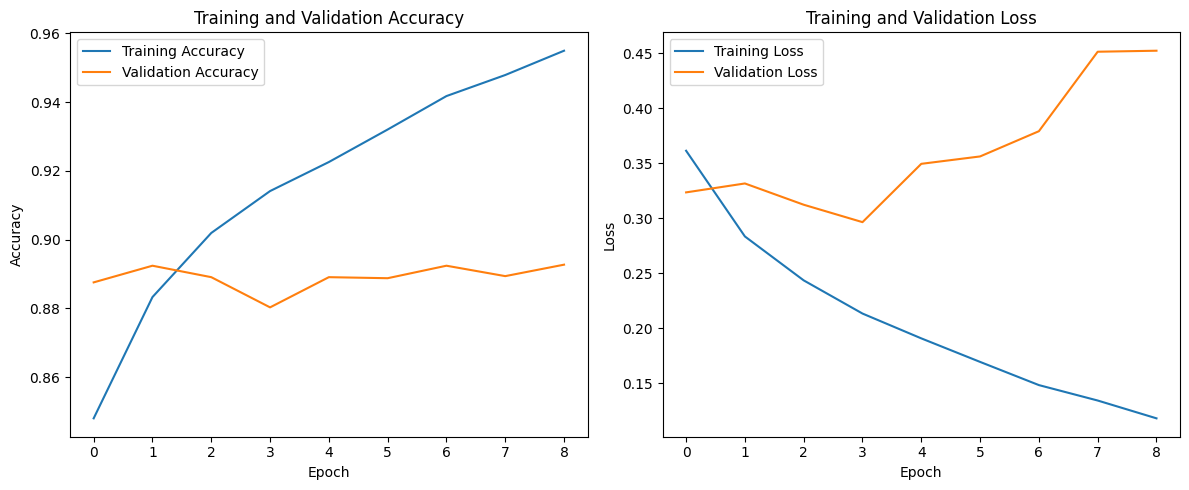

Experiment: freeze_all_transformer_layers


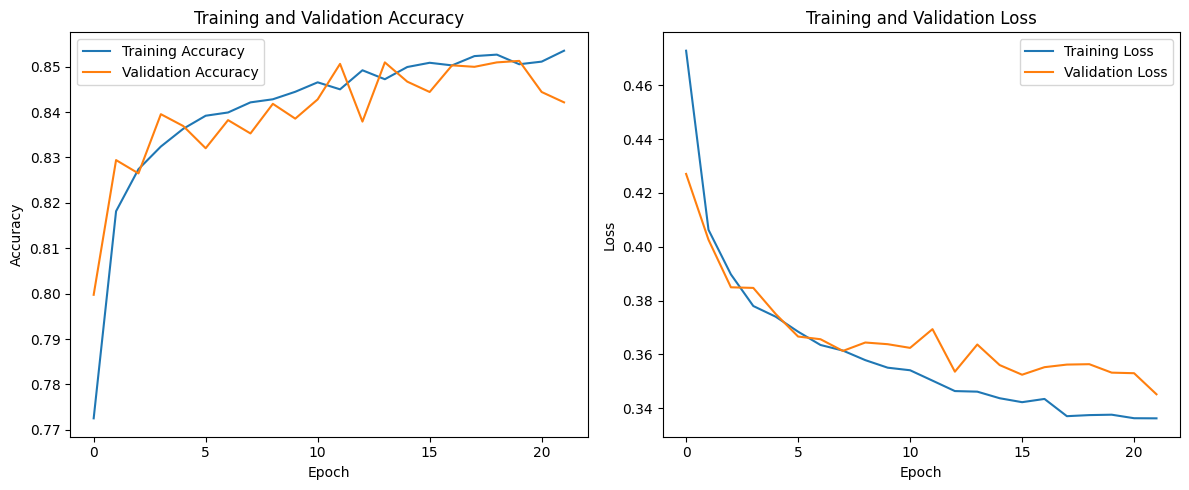

In [55]:
from toxicity_analysis.utils.model_performance_analysis import plot_training_curves
from toxicity_analysis.utils.constants import CHECKPOINT_PATHS, METRICS_JSON_FILE, TRAIN_LOSS_HIST, TRAIN_ACC_HIST, VAL_LOSS_HIST, VAL_ACC_HIST

# Plot training and validation curves for both accuracy and loss metrics
# for each one of the three experiments defined
for experiment_name, experiment_path in CHECKPOINT_PATHS.items():
  with open(os.path.join(experiment_path, METRICS_JSON_FILE), 'r') as f:
    metrics = json.load(f)

  print(f"Experiment: {experiment_name}")
  plot_training_curves(train_accs = metrics[TRAIN_ACC_HIST], train_losses = metrics[TRAIN_LOSS_HIST],
                        val_accs = metrics[VAL_ACC_HIST], val_losses = metrics[VAL_LOSS_HIST],)

Como podemos observar, **el modelo hace _overfitting_ rápidamente con el planteamiento original** (congelando sólo la capa de _embeddings_). Esto estaba destinado a suceder, ya que DistilBERT es un modelo bastante grande (135M de parámetros) y la cantidad de datos de entrenamiento es muy pequeña (sobre los 30K).

<u>Lo ideal para obtener mejores resultados habría sido ampliar los datos de entrenamiento</u> (por ejemplo, usando el dataset FredZhang7/toxi-text-3M); pero no he podido probarlo por falta de tiempo. Por tanto, se ha optado por la otra posible vía: <u>reducir la complejidad del modelo congelando diversos bloques de Transformer</u>.

Se puede observar que congelando todos los bloques de Transformer menos el último, <u>la reducción del sobreajuste es mínima pero el impacto en la progresión de la precisión no tanto</u> (la ralentiza tanto que hace que se estanque en valores más bajos). Este efecto se ve todavía más claro cuando se congelan todos los bloques de Transformer del modelo (último experimento). Por tanto, elegiremos como mejor modelo aquel que minimice la _loss_ del plantemiento original, ya que es donde los datos de validación alcanzan su precisión máxima.

**Matrices de confusión**

In [56]:
from toxicity_analysis.utils.model_performance_analysis import predict_with_probabilities
from toxicity_analysis.utils.constants import CHECKPOINT_PATHS, BEST_MODEL, FREEZE_ALL_TRANSFORMER_LAYERS

val_set_by_lang = single_language_datasets[VAL]

# Get best model predictions (for each experiment) for the validation set.
# Set confidence threshold to 0.5. This is the minimum probability to predict
# a text as 'toxic'. This value can be tuned to maximize model's accuracy
# However, due to the very little size of validation data (3K), it is not
# representative enough to fit a precision-recall curve
predictions_by_experiment = {}
for experiment_name, experiment_path in CHECKPOINT_PATHS.items():
    predictions_by_experiment[experiment_name] = predict_with_probabilities(model_path = os.path.join(CHECKPOINT_PATHS[experiment_name], BEST_MODEL),
                                                                      tokenizer = tokenizer,
                                                                      df_by_language=val_set_by_lang,
                                                                      device=device, conf_th = 0.5)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at lxyuan/distilbert-base-multilingual-cased-sentiments-student and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([3]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([3, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Predicting for French: 100%|██████████| 31/31 [00:01<00:00, 20.54it/s]
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at lxyuan/distilbert-base-multilingual-cased-sentiments-student and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([3]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found 

only_freeze_embeddings


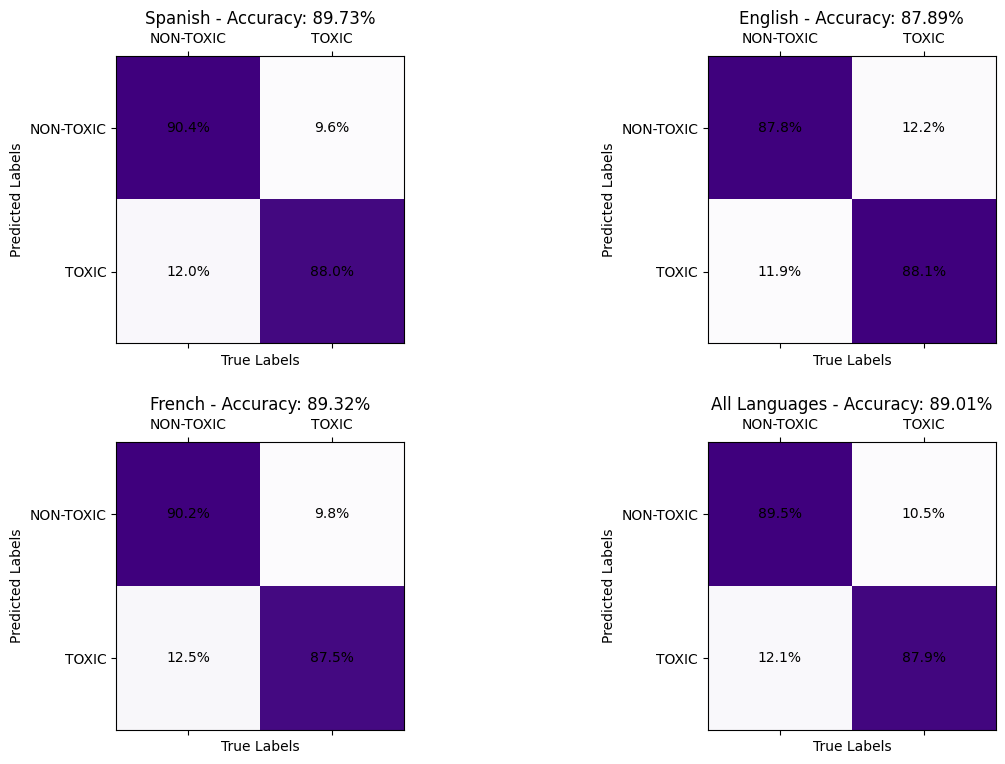

freeze_all_transformer_layers_except_last


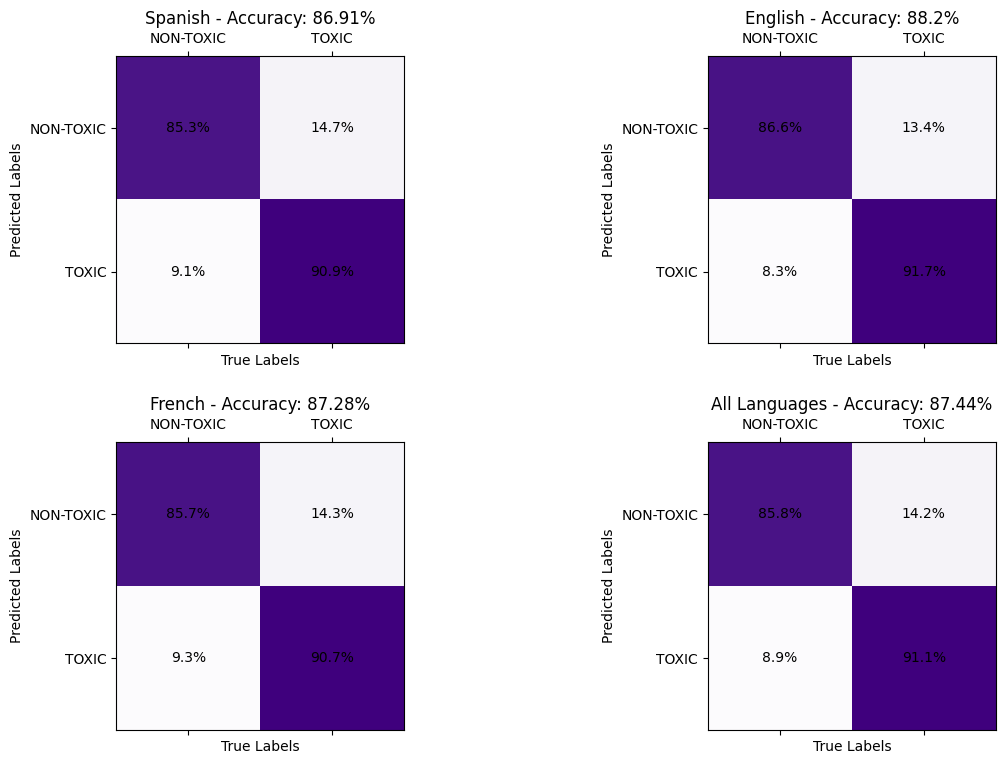

freeze_all_transformer_layers


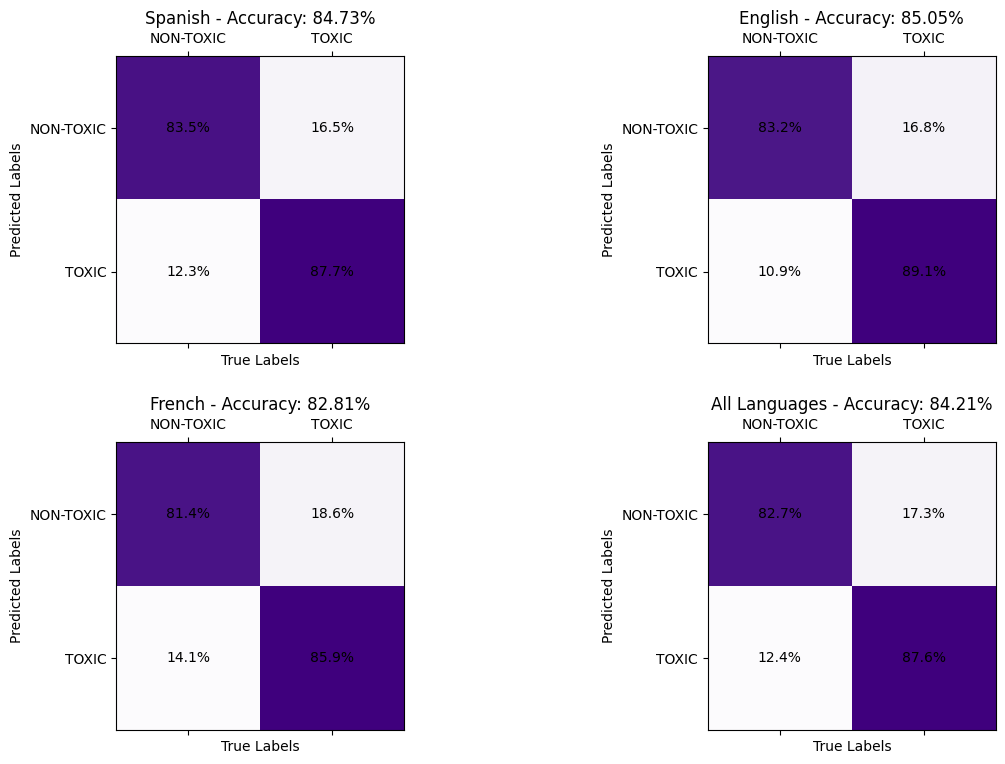

In [57]:
from toxicity_analysis.utils.model_performance_analysis import plot_combined_precision_recall_curve, show_confusion_matrix

# Show the confusion matrices of the best model per experiment
# filtered by language and for all data
for experiment_name, predictions_by_lang in predictions_by_experiment.items():
    print(f"{experiment_name}")
    show_confusion_matrix(labels_and_predictions_by_lang=predictions_by_lang)

Podemos observar que la distribución de resultados es muy similar para el mejor modelo de cada uno de los experimentos, pero que **la mayor precisión se alcanza cuando se congelan sólo la capa de _embeddings_**. Como curiosidad, este es el único caso en que la clase "toxic" consigue mejores resultados que "non-toxic", aunque también es la que muestra unas precisiones más balanceadas.

Notar que, a pesar del alto desbalanceo de las clases en los datos de entrenamiento, <u>se han obtenido precisiones muy similares para ambas clases y además de forma consistente a lo largo de los diferentes experimentos</u>.

**Curva de _precision-recall_**

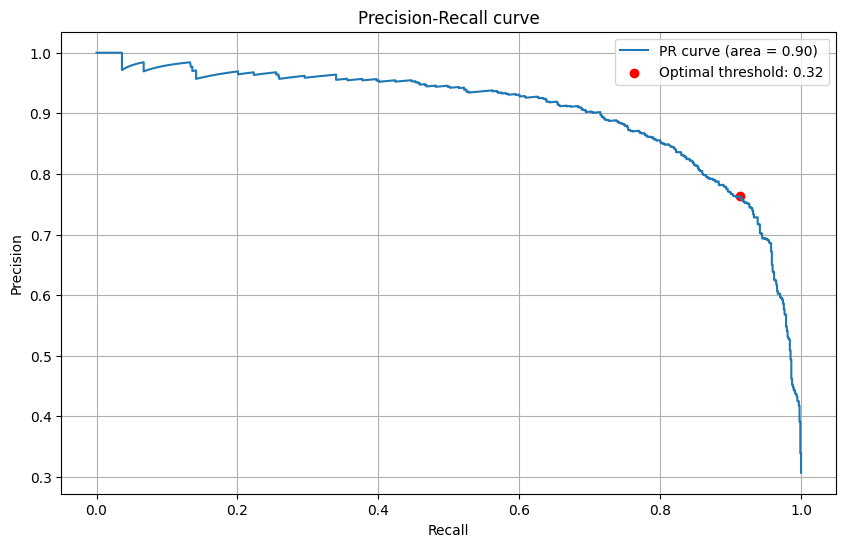

In [58]:
plot_combined_precision_recall_curve(results_by_lang=predictions_by_experiment[ONLY_FREEZE_EMBEDDINGS])

Debido a que las clases de los datos de entrenamiento están muy desbalanceadas, es de interés obtener la curva de _precission-recall_:
- La <u>precisión</u> mide la proporción de _true positives_ entre el total de datos. A mayor precisión, menos _falsos positivos_.
- El <u>_recall_</u> mide la proporción de _true positives_ entre el número de datos con clase _positive_, ya estuvieran correctamente o incorrectamente clasificados por el modelo. A mayor sensibilidad, menos _falsos negativos_.

Una elevada área bajo esta curva (AUC) de _precision-recall_ implica un alto equilibro entre ambas métricas. **Teniendo una AUC de 0.9, podemos afirmar que se trata de un buen modelo para esta tarea de clasificación**. Vemos también que el _confidence threshold_ óptimo del modelo para los datos de validación es de 0.32. Al tratarse de un conjunto tan pequeño de datos, no considero que sea un valor de referencia como para poder usarlo en la evaluación de los datos de _test_, así que usaremos el estándar 0.5.

#Evaluación del modelo final sobre los datos de _test_

**Matrices de confusión**

In [59]:
# Get TEST data
test_set_by_lang = deepcopy(single_language_datasets[TEST])

checkpoint_path = CHECKPOINT_PATHS[ONLY_FREEZE_EMBEDDINGS]  # Select best model manually
predictions_by_lang = predict_with_probabilities(model_path = os.path.join(checkpoint_path, BEST_MODEL),  # Obtain TEST predictions
                                                 tokenizer = tokenizer, df_by_language=test_set_by_lang, device=device, conf_th = 0.5)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at lxyuan/distilbert-base-multilingual-cased-sentiments-student and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([3]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([3, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Predicting for French: 100%|██████████| 156/156 [00:16<00:00,  9.46it/s]


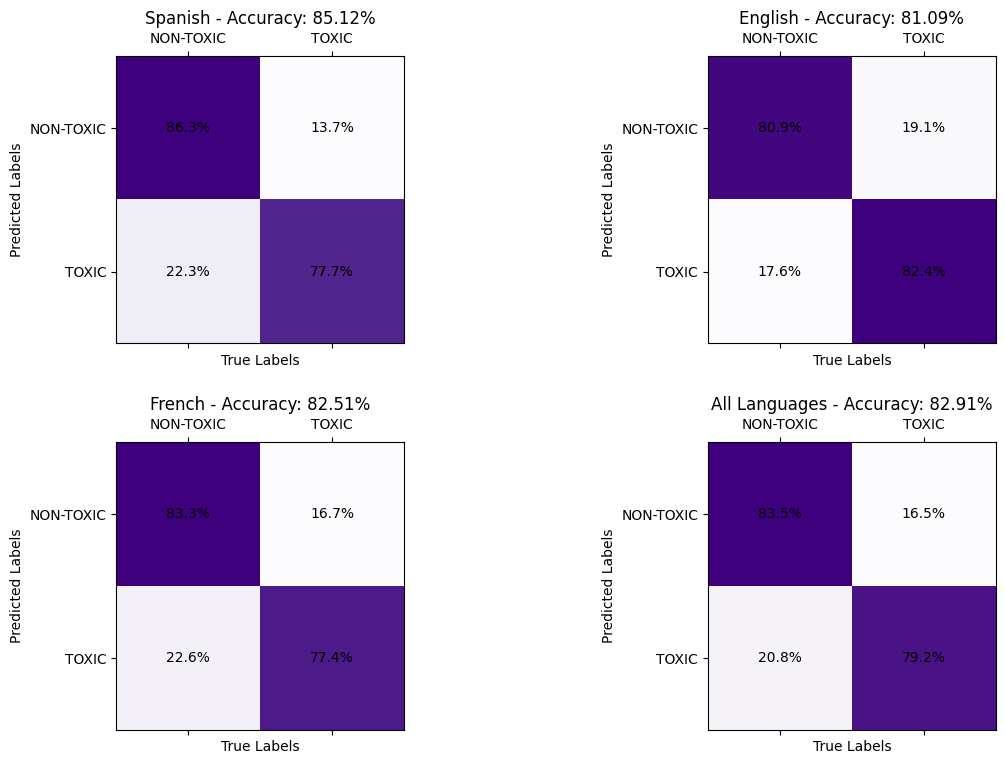

In [60]:
show_confusion_matrix(labels_and_predictions_by_lang=predictions_by_lang)

La distribución mostrada en la matriz de confusión de los datos de _test_ no difiere demasiado de lo ya visto en validación. Ya sabíamos que la distribución de los datos era similar, así que es un comportamiento esperado. Observaciones:
- Al igual que en validación, <u>la precisión en distintos idiomas difiere ligeramente</u>, pero no se siente desbalanceado. Estas diferencias se deben principalmente a las distancias entre la precisión de ambas clases, donde vemos que el modelo inglés es el más robusto y en los idiomas español y francés hay diferencias más acusadas.
- <u>El modelo predice con mayor precisión generalmente los mensajes no tóxicos que los tóxicos</u>, al igual que sucedía en validación.
- Finalmente, la precisión general baja ligeramente de 84.2% a 82.9%.

**Análisis de sesgos**

In [62]:
from toxicity_analysis.utils.model_performance_analysis import find_top_failures, visualize_top_failures

top_failures = find_top_failures(dataset_by_language=test_set_by_lang, matches_by_language=predictions_by_lang, top_failures=10)
display(visualize_top_failures(top_failures_by_language=top_failures))

En esta última sección de análisis, he seleccionado los diez _falsos positivos_ y los diez _falsos negativos_ con mayor _confindence_ (probabilidad de la clase seleccionada) para ver en qué puede estar fallando el modelo en aquellas predicciones de las que está más seguro.

---

Analizando los <u>FALSOS POSITIVOS</u>... **Si consideramos "tóxicos" aquellos textos llenos de descalificativos y con clara intención agresiva, violenta y lesiva**, que es el tipo de mensajes que he podido encontrar en el análisis semántico de los datos, **no se puede clasificar**...

"Sólo en un día, hemos conocido una tienda de ropa que vende camisetas con elogios a Abascal y amenazas de muerte a Pablo Iglesias y las amenazas también de muerte y con dos balas al ex-presidente Zapatero. Condena sin "peros" al **terrorismo fascista** y a los que lo blanquean."

...**como "no tóxico"** cuando emplea el término "terrorismo fascista".

Lo mismo pasa con el segundo mensaje, que es claramente pasivo agresivo, o el cuarto, que dice "el Gobierno se apoya de socios populistas y nacionalistas". **<u>Todo apunta a que el motivo principal de los falsos positivos en los datos de _test_ sea un etiquetado incorrecto</u>**.

En los casos donde claramente se equivoca (que son minoría), todo apunta a que se debe a que son casos donde se emplean términos con connotación muy negativa:
- "El #4M tenemos una oportunidad histórica para dar un ejemplo de tolerancia. Os doy mi palabra: jamás contribuiré al **enfrentamiento**. Si no **insultáis**, votad a quienes no **insultamos** Si respetáis a quienes piensan distinto, votad a quienes respetamos a todos"
- "Samuel tenía 24 años y toda la vida por delante. Le han dado una **paliza** hasta **matarlo**, por ser gay. Le gritaban "maricon" cada **insulto**, también es insulto para todos nosotros. Esto ha ocurrido en el 2021. ¡Lo han **asesinado**! #justiciaparasamuel"

Al tratarse de un modelo que ha sido _fine-tuneado_ a partir de un modelo pensando para la tarea de **_sentiment analysis_**, no me extraña ver que **clasifica como tóxicos aquellos mensajes llenos de términos muy negativos**, sin atender correctamente a los matices, sobre todo cuando la cantidad de datos de entrenamiento es tan pequeña.

---
En el caso de los <u>FALSOS NEGATIVOS</u>... podemos observar que **<u>claramente no es capaz de detectar las sutilezas que implica la elección de ciertas palabras</u>**:
- "Incluso en los momentos más tensos habidos cuando **desgobernaba** un **tipo** llamado Rodríguez Zapatero, hubo puentes y alcantarillas."
- "Sin la moción de 1980 no hubiera sido posible 1982, de manera que hoy recordaríamos 1982 solo por Naranjito y por el Gobierno de Unidad Nacional presidido por el General Armada –del que Felipe fue vicepresidente tercero–, que tanto hizo por una España feliz y unida, **sin mariconadas**, de ahí el mausoleo de Armada, financiado por Endesa y edificado por Calatrava en el homónimo Valle de Armada, en Armadia, antes provincia de Madrid."

**Tampoco parece hacerlo bien con textos cortos debido a la falta de un mayor contexto**: "Former criminal congressman".

He de mencionar también que, aunque mucho menos minoritarios en el caso de los falsos positivos, <u>aquí también hay textos mal clasificados</u>, por ejemplo: "De mantenerse las tasas de natalidad actuales en España, en 2055 el tramo quinquenal de edad más numeroso será el 75-79. El 2º más numeroso, el 80-84. Habrá más octogenarios que veinteañeros". @georgina_vox :" no veo que sea tóxico.

---

En resumen, a pesar de que el modelo funciona bastante bien, **se deja llevar muy a menudo por el tono y negatividad de los términos empleados en los textos**. Por ejemplo, no es capaz de clasificar un texto de denuncia que no ataca a nadie como "no tóxico" porque contiene términos como "paliza" o "asesinado"; ni tampoco identificar la toxicidad en mensajes aparentemente neutros y calmados que introducen <u>críticas sutiles, especialmente cuando estas sólo aparecen en el _hashtag_</u> (Ejemplo: #PGEdelaRuina, #ParemosSuAgenda).

Para obtener un modelo mucho más robusto, que pueda **comprender con mayor profundidad el contenido y las intenciones de estos mensajes en aquellos casos <u>menos evidentes</u>, debemos emplear un conjunto de datos de entrenamiento órdenes de magnitud más extenso que el actual** (mínimo x10), para permitir que generalice correctamente y pueda hacer una mejor transición de _sentiment analysis_ a _toxicity detection_. Aun así, <u>los resultados son muy prometedores para disponer de un dataset tan reducido</u>.

Por último, indicar que <u>si los datos no están correctamente etiquetadoss </u>(hay muchos menos textos clasificados como tóxicos de los que debería); <u>no se puede realizar una evaluación precisa</u>.

#Cuestiones

**Si tuvieses acceso a un LLMs (ChatGPT, LLaMa, etc, ¿Lo usarías? En caso afirmativo desarrolla la respuesta**

No. Para las tareas de clasificación en el ámbito de NLP no necesitamos arquitecturas con bloque de _decoder_, ya que nuestro objetivo no es generar texto, si no comprender el texto que llega en el input lo mejor posible. Además, los LLM son modelos enormes como su propio nombre indica (con muchísimos más parámetros que el DistilBERT que hemos empleado en este _notebook_); lo cual requiere de una cantidad muchísimo más grande de datos para obtener un buen resultado. Teniendo en cuenta que necesitamos datos etiquetados para realizar esta tarea (se trata de clasificación supervisada), aumentar el tamaño del dataset de entrenamiento tantísimo sería especialmente costoso.

En resumen, mejor no _matar moscas a cañonazos_: la solución más sencilla suele ser la mejor opción.